In [1]:
pip install wandb scipy seaborn matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


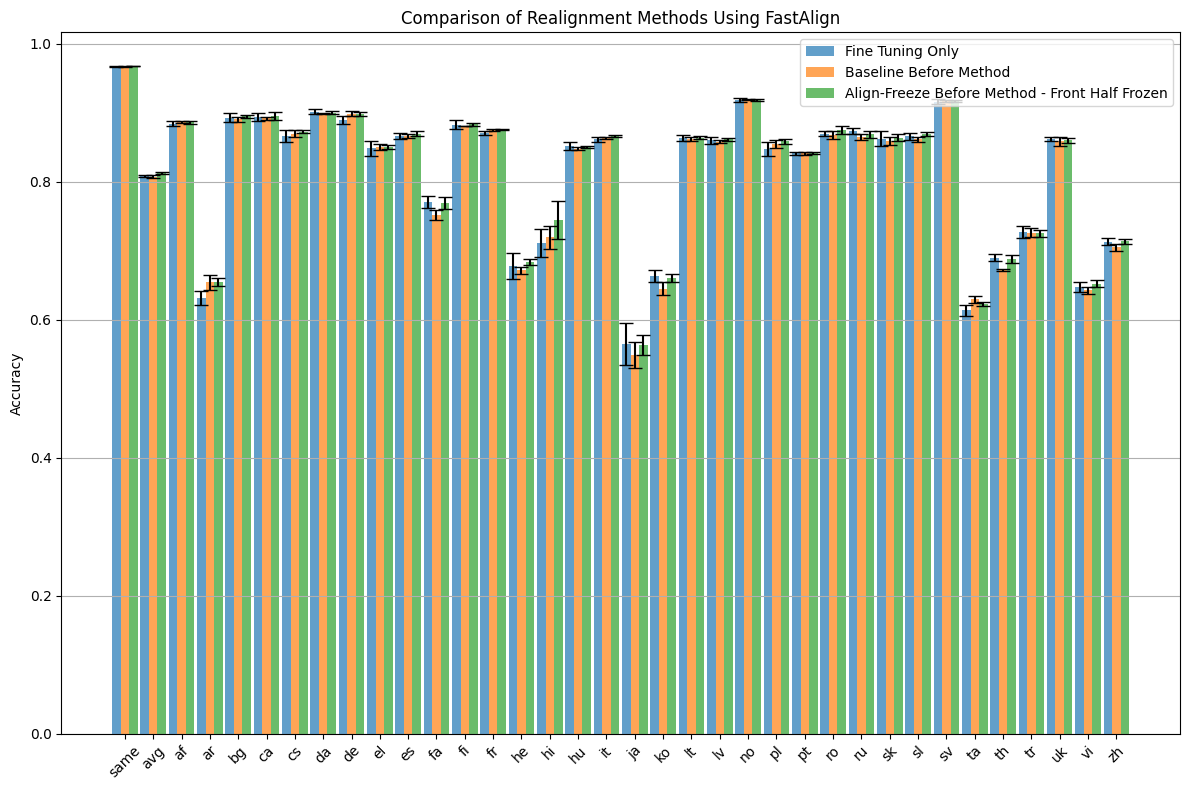

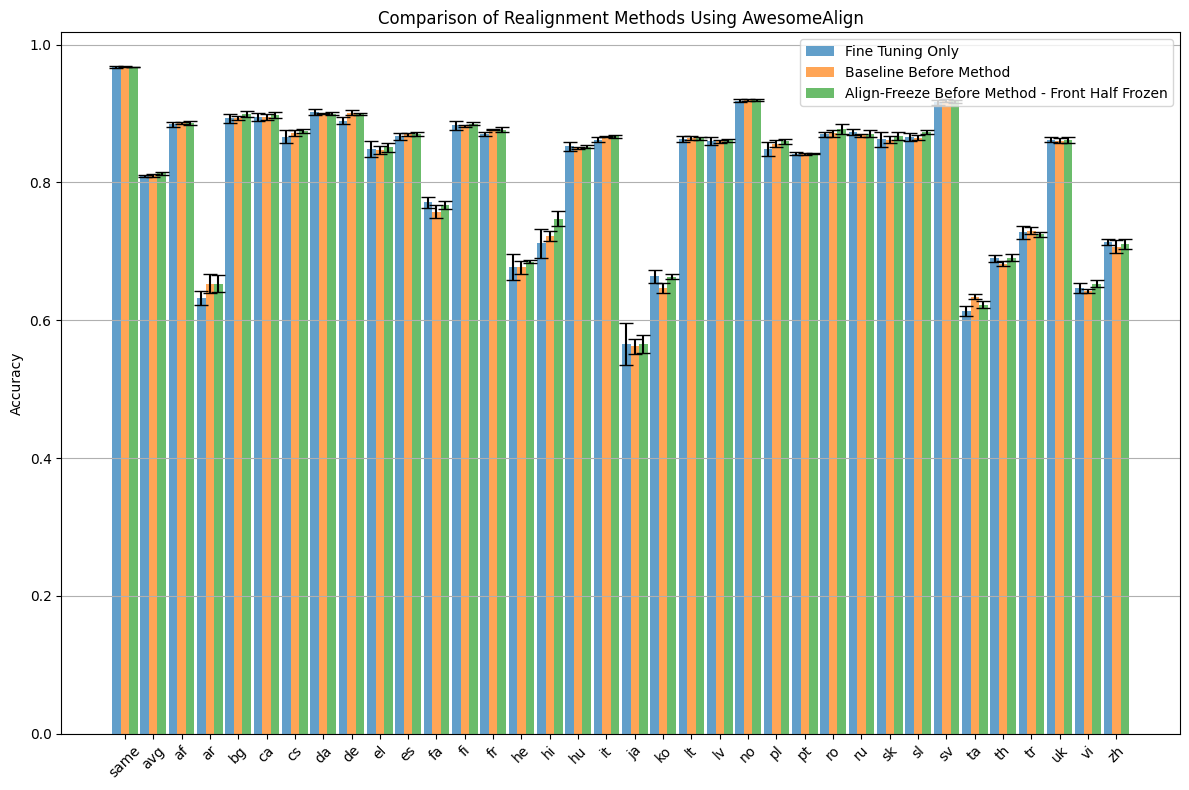

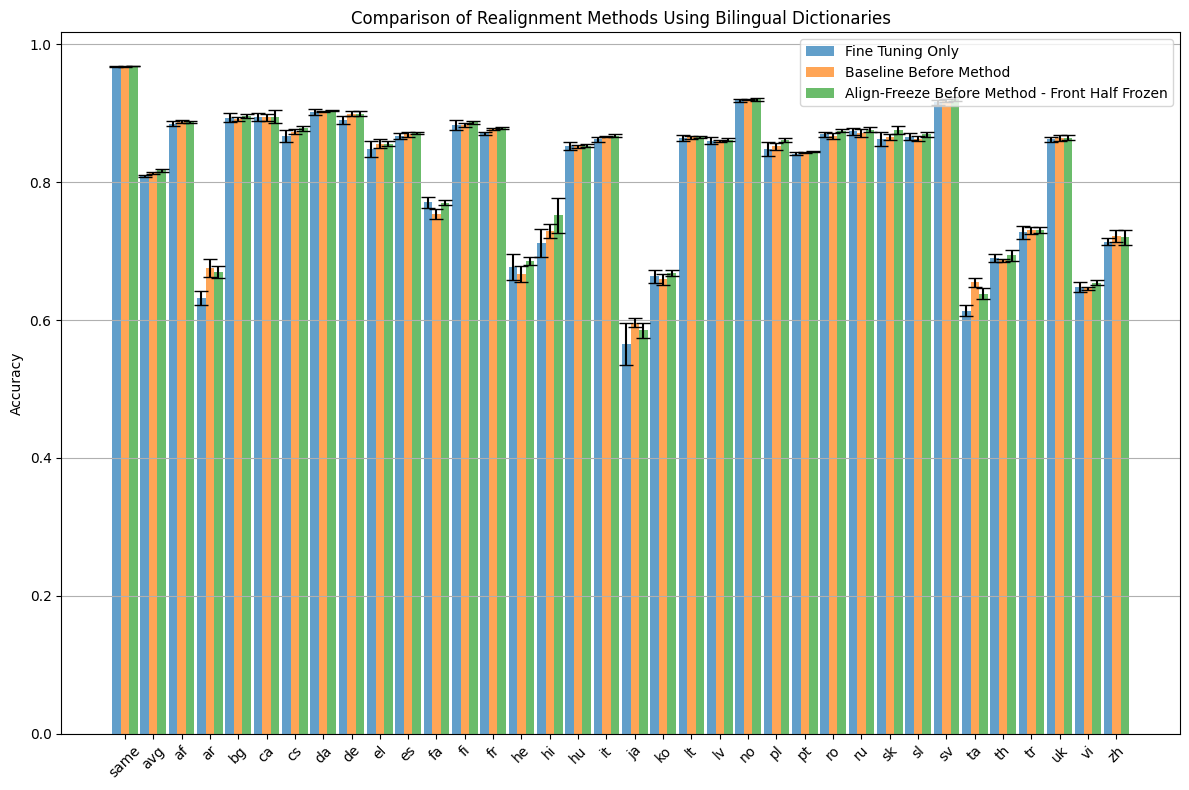

In [3]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import seaborn as sns
import pandas as pd


api = wandb.Api()


workspace = "align_freeze"


finetuning_project_name = "3nl_34langs_baseline_udpos"


project_pairs = [
    ("3nl_34langs_before_fastalign_udpos", "3nl_34langs_freeze_realign_unfreeze_fastalign_udpos"),
    ("3nl_34langs_before_awesome_udpos", "3nl_34langs_freeze_realign_unfreeze_awesome_udpos"),
    ("3nl_34langs_before_dico_udpos", "3nl_34langs_freeze_realign_unfreeze_dico_udpos"),
]


langs = ["same", "avg", "af", "ar", "bg", "ca", "cs", "da", "de", "el", "es", "fa", "fi", "fr", "he", "hi",
         "hu", "it", "ja", "ko", "lt", 'lv', 'no', 'pl', 'pt', 'ro', 'ru', 'sk', 'sl', 'sv', 'ta', 'th', 'tr', 'uk',
         'vi', 'zh']

filtered_langs = ["same", "avg", "af", "ar", "es", "fa", "fr", "hi", 'ru', 'zh']


def fetch_and_process_runs(source, _langs, username="felixgaschi", method_name=None):
    runs_data = {lang: [] for lang in _langs}
    
    
    if source.endswith('.csv'):
        df = pd.read_csv(source)
        
        
        if method_name:
            df = df[df['method'] == method_name]
        
        
        for lang in _langs:
            accuracy_key = f'eval_{lang}_accuracy'
            if accuracy_key in df.columns:
                runs_data[lang] = df[accuracy_key].dropna().tolist()
            else:
                print(f"{lang} not in CSV...")
    else:
    
        runs = api.runs(f"{workspace}/{source}")
        for run in runs:
            if run.user.username == username:  
                for lang in langs:
                    accuracy_key = f"eval_{lang}_accuracy"
                    accuracy = run.summary.get(accuracy_key)
                    if accuracy is not None:
                        runs_data[lang].append(accuracy)
        assert all([len(runs) == 5 for language, runs in runs_data.items()])
    return runs_data


finetuning_only = fetch_and_process_runs(finetuning_project_name, langs)


def plot_comparison(finetuning_only, baseline_data, freezing_data, langs, baseline_name, freezing_name, global_baseline_title, baseline_title, new_method_title):
    width = 0.3  
    x = np.arange(len(langs))  

    fig, ax = plt.subplots(figsize=(12, 8))

    global_baseline_means = [np.mean(finetuning_only[lang]) for lang in langs]
    global_baseline_cis = [scipy.stats.sem(finetuning_only[lang]) * scipy.stats.t.ppf((1 + 0.95) / 2., len(finetuning_only[lang])-1) if finetuning_only[lang] else 0 for lang in langs]

    baseline_means = [np.mean(baseline_data[lang]) for lang in langs]
    baseline_cis = [scipy.stats.sem(baseline_data[lang]) * scipy.stats.t.ppf((1 + 0.95) / 2., len(baseline_data[lang])-1) if baseline_data[lang] else 0 for lang in langs]

    freezing_means = [np.mean(freezing_data[lang]) for lang in langs]
    freezing_cis = [scipy.stats.sem(freezing_data[lang]) * scipy.stats.t.ppf((1 + 0.95) / 2., len(freezing_data[lang])-1) if freezing_data[lang] else 0 for lang in langs]

    rects1 = ax.bar(x - width, global_baseline_means, width, yerr=global_baseline_cis, capsize=5, alpha=0.7, ecolor='black')
    rects2 = ax.bar(x, baseline_means, width, yerr=baseline_cis, label=baseline_name, capsize=5, alpha=0.7, ecolor='black')
    rects3 = ax.bar(x + width, freezing_means, width, yerr=freezing_cis, label=freezing_name, capsize=5, alpha=0.7, ecolor='black')

    ax.set_ylabel('Accuracy')
    ax.set_xticks(x)
    ax.set_xticklabels(langs)
    aligner_name = baseline_name.split('_')[-2]
    if aligner_name == 'dico':
        aligner_name = 'Bilingual Dictionaries'
    elif aligner_name == 'awesome':
        aligner_name = 'AwesomeAlign'
    elif aligner_name == 'fastalign':
        aligner_name = 'FastAlign'
    ax.set_title(f"Comparison of Realignment Methods Using {aligner_name}")
    ax.legend([global_baseline_title, baseline_title, new_method_title])
    ax.yaxis.grid(True)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


for baseline_project, freezing_project in project_pairs:
    baseline_data = fetch_and_process_runs(baseline_project, langs)
    freezing_data = fetch_and_process_runs(freezing_project, langs)

    
    plot_comparison(finetuning_only, baseline_data, freezing_data, 
                    langs, baseline_project, freezing_project, 
                    'Fine Tuning Only', "Baseline Before Method", 
                    "Align-Freeze Before Method - Front Half Frozen")


C:\Users\alith\AppData\Local\Temp\ipykernel_78160\3822837794.py:37: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax = sns.barplot(x='Language', y='Delta', hue='Aligner', data=combined_df, palette=palette, dodge=True)
C:\Users\alith\AppData\Local\Temp\ipykernel_78160\3822837794.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=12)


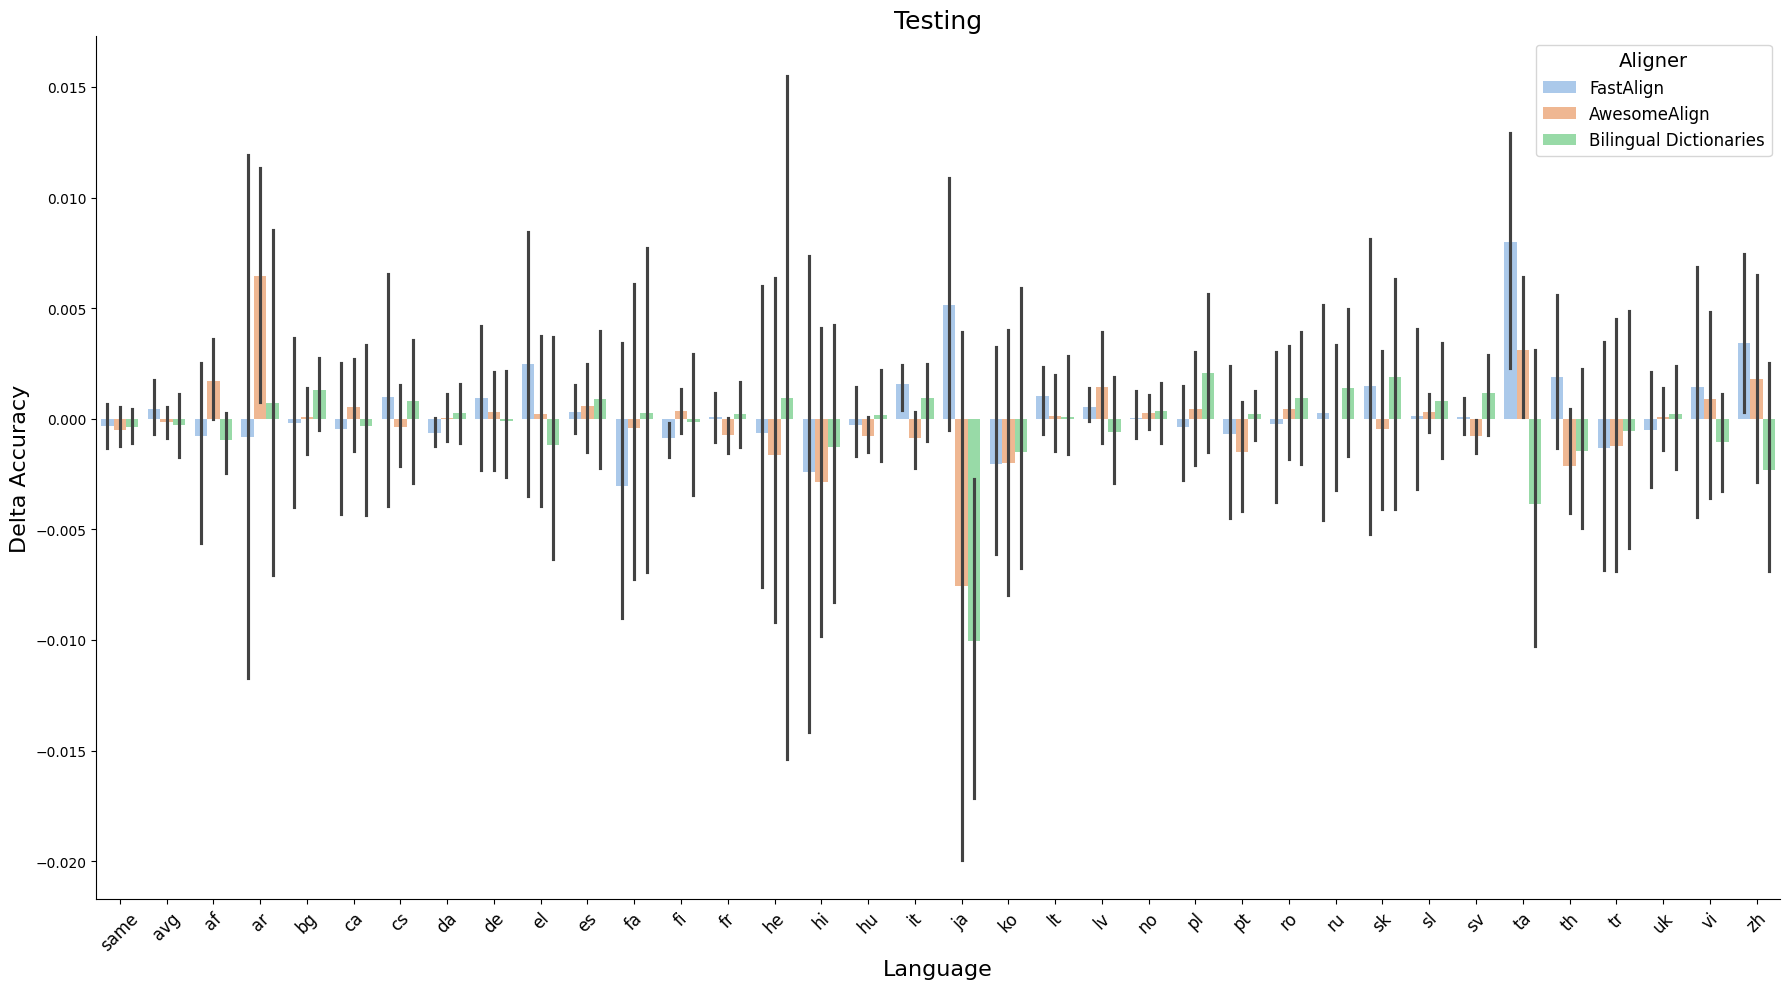

In [4]:
def plot_combined_bar_deltas_with_cis(project_pairs, _langs, hide_overlapping_bars=False, title=None):
    aligners = ['FastAlign', 'AwesomeAlign', 'Bilingual Dictionaries']
    all_delta_data = []

    
    special_langs = ['same', 'avg']
    sorted_langs = special_langs + sorted(lang for lang in _langs if lang not in special_langs)

    for ((baseline_source, baseline_method), (align_freeze_source, align_freeze_method)), aligner in zip(project_pairs, aligners):
        baseline_data = fetch_and_process_runs(baseline_source, _langs, method_name=baseline_method)
        align_freeze_data = fetch_and_process_runs(align_freeze_source, _langs, method_name=align_freeze_method)

        for lang in _langs:
            lang_deltas = [align_freeze - baseline for baseline, align_freeze in zip(baseline_data[lang], align_freeze_data[lang])]
            if not lang_deltas:
                continue  
            mean_delta = np.mean(lang_deltas)
            ci = scipy.stats.sem(lang_deltas) * scipy.stats.t.ppf((1 + 0.95) / 2., len(lang_deltas)-1)
            
            if hide_overlapping_bars and (mean_delta - ci <= 0 <= mean_delta + ci):
                continue
            all_delta_data.extend([{'Language': lang, 'Delta': delta, 'Mean Delta': mean_delta, 'CI': ci, 'Aligner': aligner} for delta in lang_deltas])

    if not all_delta_data:
        print("No data to plot.")
        return

    
    combined_df = pd.DataFrame(all_delta_data)
    combined_df['Aligner'] = pd.Categorical(combined_df['Aligner'], categories=aligners, ordered=True)
    combined_df['Language'] = pd.Categorical(combined_df['Language'], categories=sorted_langs, ordered=True)
    combined_df.sort_values(by=['Aligner', 'Language'], inplace=True)

    
    plt.figure(figsize=(18, 10))
    palette = sns.color_palette("pastel")
    ax = sns.barplot(x='Language', y='Delta', hue='Aligner', data=combined_df, palette=palette, dodge=True)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=12)
    plt.xlabel('Language', fontsize=16)
    plt.ylabel('Delta Accuracy', fontsize=16)
    plt.title(title if title else 'Delta Accuracy by Aligner', fontsize=18)
    plt.legend(title="Aligner", fontsize=12, title_fontsize=14)
    sns.despine()

    plt.tight_layout()
    plt.show()


csv = './filtered_data/opus100_filtered_0.4.csv'

project_pairs = [
    (("3nl_34langs_before_fastalign_udpos", None), (csv, "before_fastalign")),
    (("3nl_34langs_before_awesome_udpos", None), (csv, "before_awesome")),
    (("3nl_34langs_before_dico_udpos", None), (csv, "before_dico")),
]


plot_combined_bar_deltas_with_cis(project_pairs, langs, hide_overlapping_bars=False, title='Testing')


C:\Users\alith\AppData\Local\Temp\ipykernel_78160\3822837794.py:37: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax = sns.barplot(x='Language', y='Delta', hue='Aligner', data=combined_df, palette=palette, dodge=True)
C:\Users\alith\AppData\Local\Temp\ipykernel_78160\3822837794.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=12)


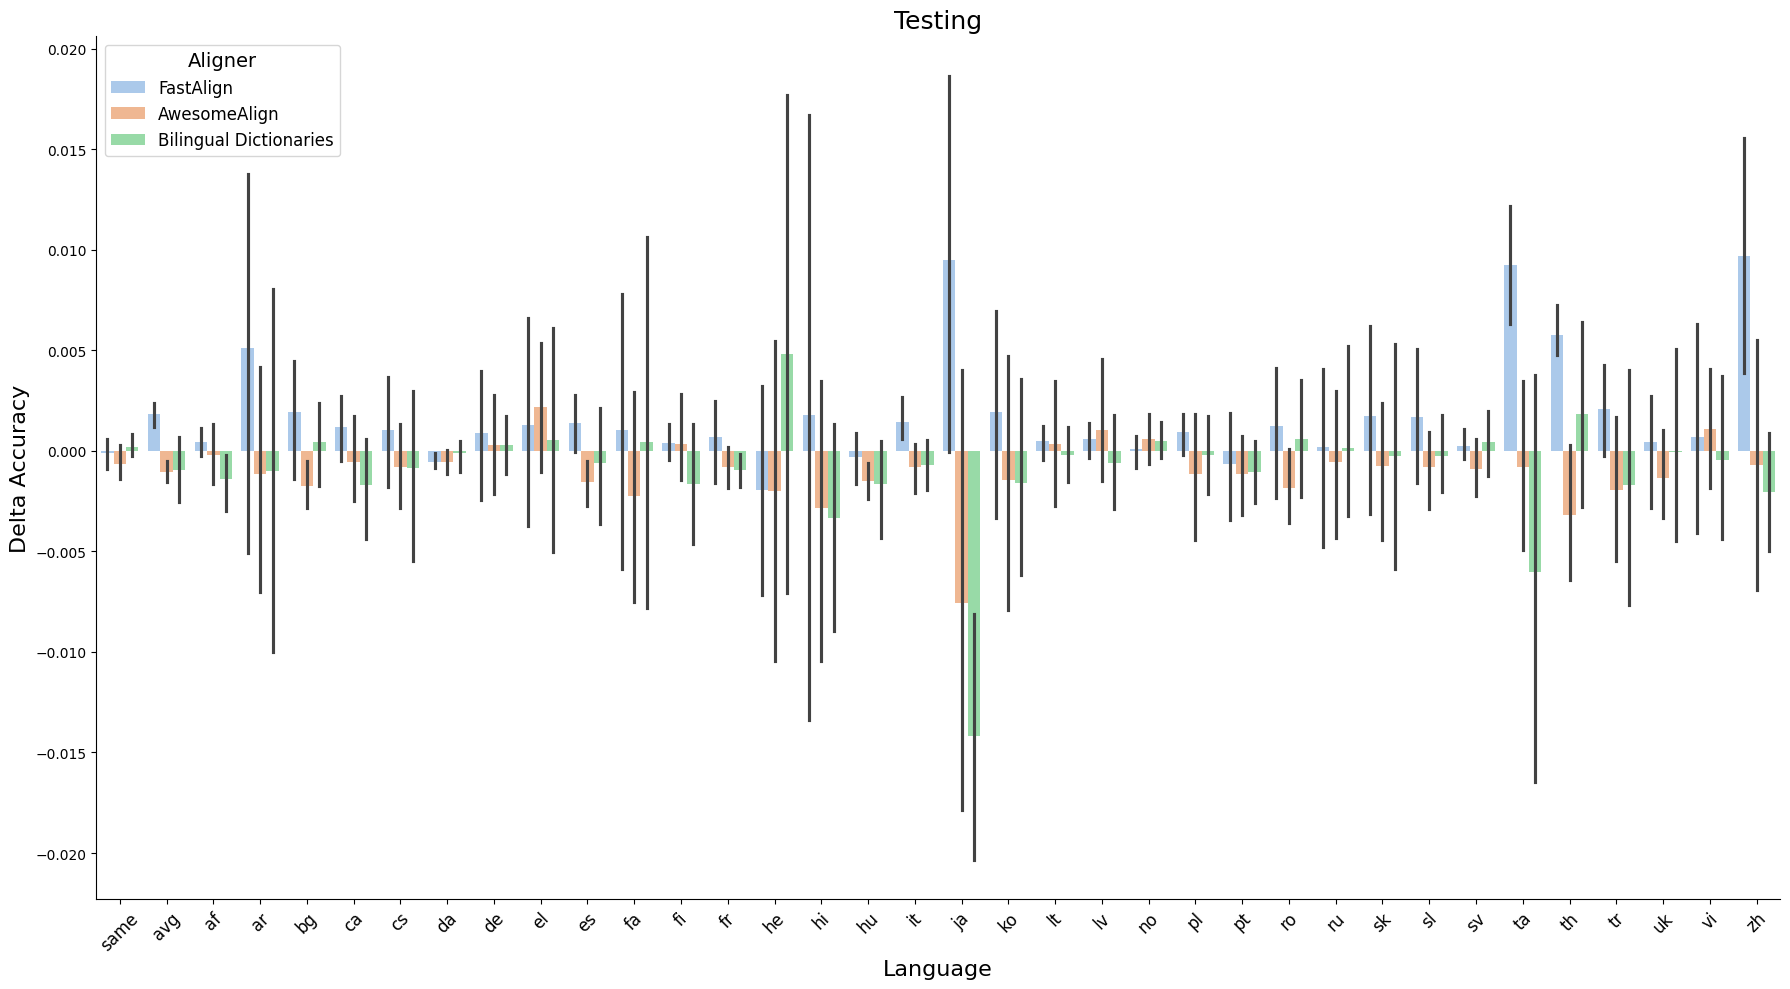

In [5]:

csv = './filtered_data/opus100_filtered_0.5.csv'

project_pairs = [
    (("3nl_34langs_before_fastalign_udpos", None), (csv, "before_fastalign")),
    (("3nl_34langs_before_awesome_udpos", None), (csv, "before_awesome")),
    (("3nl_34langs_before_dico_udpos", None), (csv, "before_dico")),
]


plot_combined_bar_deltas_with_cis(project_pairs, langs, hide_overlapping_bars=False, title='Testing')

C:\Users\alith\AppData\Local\Temp\ipykernel_78160\3822837794.py:37: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax = sns.barplot(x='Language', y='Delta', hue='Aligner', data=combined_df, palette=palette, dodge=True)
C:\Users\alith\AppData\Local\Temp\ipykernel_78160\3822837794.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=12)


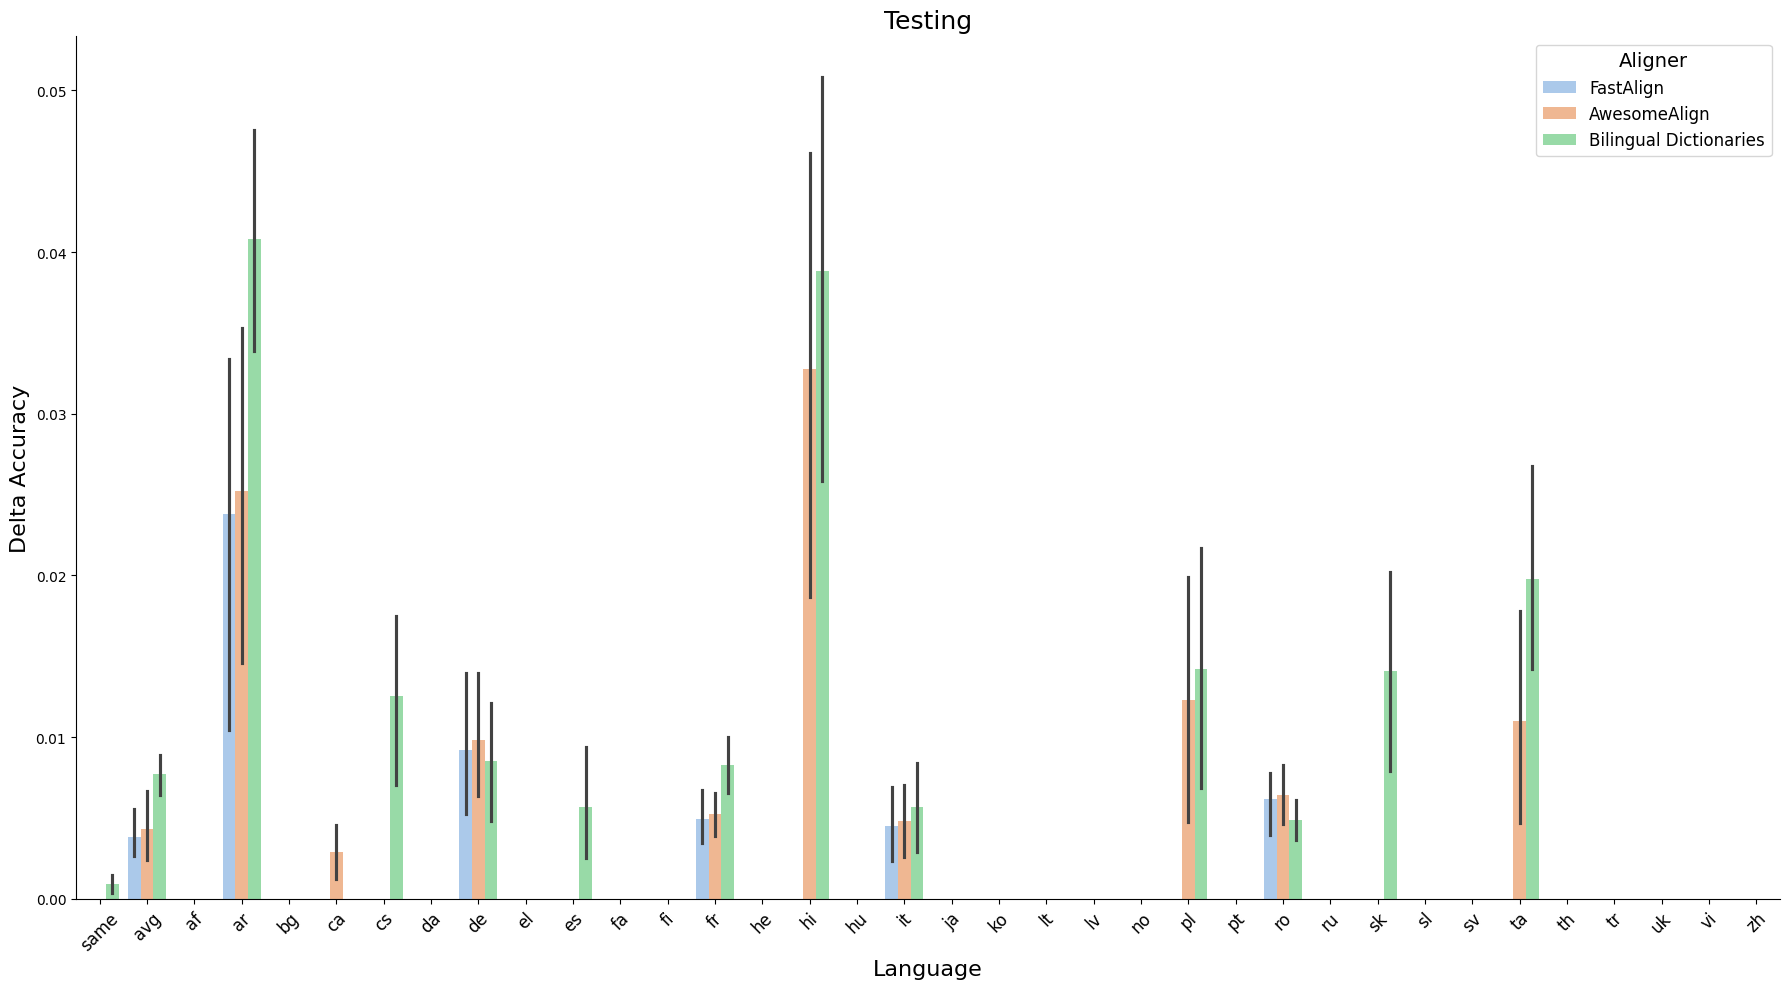

In [6]:

csv = './filtered_data/opus100_filtered_0.4.csv'

project_pairs = [
    (('3nl_34langs_baseline_udpos', None), (csv, "freeze_realign_unfreeze_fastalign")),
    (('3nl_34langs_baseline_udpos', None), (csv, "freeze_realign_unfreeze_awesome")),
    (('3nl_34langs_baseline_udpos', None), (csv, "freeze_realign_unfreeze_dico")),
]


plot_combined_bar_deltas_with_cis(project_pairs, langs, hide_overlapping_bars=True, title='Testing')

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import t

def plot_layered_bar_deltas(project_pairs, _langs, title=None, show_error_bars=False, hide_bars_crossing_zero=False, legend_suffixes=None):
    aligners = ['FastAlign', 'AwesomeAlign', 'Bilingual Dictionaries']
    all_delta_data = []

    
    finetuning_data = fetch_and_process_runs('./filtered_data/opus100_filtered_0.4.csv', _langs=_langs, method_name='baseline')

    for ((original_source, baseline_method), (align_freeze_source, align_freeze_method)), aligner in zip(project_pairs, aligners):
        original_data = fetch_and_process_runs(original_source, _langs, method_name=baseline_method)
        align_freeze_data = fetch_and_process_runs(align_freeze_source, _langs, method_name=align_freeze_method)

        
        for lang in _langs:
            original_deltas = [baseline - finetuning for finetuning, baseline in zip(finetuning_data[lang], original_data[lang])]
            align_freeze_deltas = [align_freeze - finetuning for finetuning, align_freeze in zip(finetuning_data[lang], align_freeze_data[lang])]

            original_delta_mean = np.mean(original_deltas)
            align_freeze_delta_mean = np.mean(align_freeze_deltas)
            
            
            original_delta_se = np.std(original_deltas, ddof=1) / np.sqrt(len(original_deltas))
            align_freeze_delta_se = np.std(align_freeze_deltas, ddof=1) / np.sqrt(len(align_freeze_deltas))

            
            t_score_original = t.ppf(0.975, df=len(original_deltas)-1)  
            t_score_align_freeze = t.ppf(0.975, df=len(align_freeze_deltas)-1)

            
            original_delta_margin = t_score_original * original_delta_se
            align_freeze_delta_margin = t_score_align_freeze * align_freeze_delta_se

            
            
            

            all_delta_data.append({'Language': lang, 'Mean Delta': original_delta_mean, 'CI Margin': original_delta_margin, 'Method': f'{aligner} Original', 'Aligner': aligner})
            all_delta_data.append({'Language': lang, 'Mean Delta': align_freeze_delta_mean, 'CI Margin': align_freeze_delta_margin, 'Method': f'{aligner} Align Freeze', 'Aligner': aligner})

    
    combined_df = pd.DataFrame(all_delta_data)
    combined_df['Aligner'] = pd.Categorical(combined_df['Aligner'], categories=aligners, ordered=True)
    combined_df['Language'] = pd.Categorical(combined_df['Language'], categories=['same', 'avg'] + sorted(set(_langs) - set(['same', 'avg'])), ordered=True)
    combined_df.sort_values(by=['Language', 'Aligner', 'Method'], inplace=True)

    
    plt.figure(figsize=(20, 10))
    width = 0.25  
    colors = {
        'FastAlign Original': 'skyblue', 
        'FastAlign Align Freeze': 'blue', 
        'AwesomeAlign Original': 'lightgreen', 
        'AwesomeAlign Align Freeze': 'green',
        'Bilingual Dictionaries Original': 'salmon', 
        'Bilingual Dictionaries Align Freeze': 'red'
    }

    
    def ci_crosses_zero(delta, ci_margin):
        return delta - ci_margin <= 0 <= delta + ci_margin

    
    def plot_bar(position, delta, ci_margin, color, method, with_error_bars, hide_bars_crossing_zero):
        
        if hide_bars_crossing_zero and ci_crosses_zero(delta, ci_margin):
            return

        if not show_error_bars:
            with_error_bars = False

        
        plt.bar(position, delta, width, color=color, label=method, yerr=ci_margin if with_error_bars else None, capsize=5 if with_error_bars else None)

    
    for i, aligner in enumerate(aligners):
        for j, lang in enumerate(combined_df['Language'].unique()):
            
            original_method_label = f'{aligner} Original'
            alignfreeze_method_label = f'{aligner} Align Freeze'

            
            original_data = combined_df[(combined_df['Language'] == lang) & (combined_df['Method'] == original_method_label)]
            alignfreeze_data = combined_df[(combined_df['Language'] == lang) & (combined_df['Method'] == alignfreeze_method_label)]

            
            original_delta = round(original_data['Mean Delta'].values[0], 4)
            alignfreeze_delta = round(alignfreeze_data['Mean Delta'].values[0], 4)
            original_ci_margin = original_data['CI Margin'].values[0]
            alignfreeze_ci_margin = alignfreeze_data['CI Margin'].values[0]

            
            position = j + (i - 1) * width

            
            larger_method_is_original = abs(original_delta) > abs(alignfreeze_delta)

            
            if larger_method_is_original:
                plot_bar(position, original_delta, original_ci_margin, colors[original_method_label], original_method_label, True, hide_bars_crossing_zero)
                plot_bar(position, alignfreeze_delta, alignfreeze_ci_margin, colors[alignfreeze_method_label], alignfreeze_method_label, False, hide_bars_crossing_zero)
            else:
                plot_bar(position, alignfreeze_delta, alignfreeze_ci_margin, colors[alignfreeze_method_label], alignfreeze_method_label, True, hide_bars_crossing_zero)
                plot_bar(position, original_delta, original_ci_margin, colors[original_method_label], original_method_label, False, hide_bars_crossing_zero)

    
    plt.xticks(np.arange(len(combined_df['Language'].unique())), combined_df['Language'].unique(), rotation=45, fontsize=12)

    
    plt.xlabel('Language', fontsize=16)
    plt.ylabel('Delta Accuracy', fontsize=16)  
    plt.title(title if title else "Delta Accuracy (Original Vs Align Freeze)", fontsize=18)

    
    legend_handles = []
    for aligner in aligners:
        if legend_suffixes:
            legend_handles.append(plt.Line2D([0], [0], color=colors[f'{aligner} Original'], lw=4, label=f'{aligner} {legend_suffixes[0]}'))
            legend_handles.append(plt.Line2D([0], [0], color=colors[f'{aligner} Align Freeze'], lw=4, label=f'{aligner} {legend_suffixes[1]}'))
        else:
            legend_handles.append(plt.Line2D([0], [0], color=colors[f'{aligner} Original'], lw=4, label=f'{aligner} Original'))
            legend_handles.append(plt.Line2D([0], [0], color=colors[f'{aligner} Align Freeze'], lw=4, label=f'{aligner} Align Freeze'))

    
    plt.legend(handles=legend_handles, title="Method", fontsize=12, title_fontsize=14, loc='lower left')

    plt.tight_layout()
    plt.show()


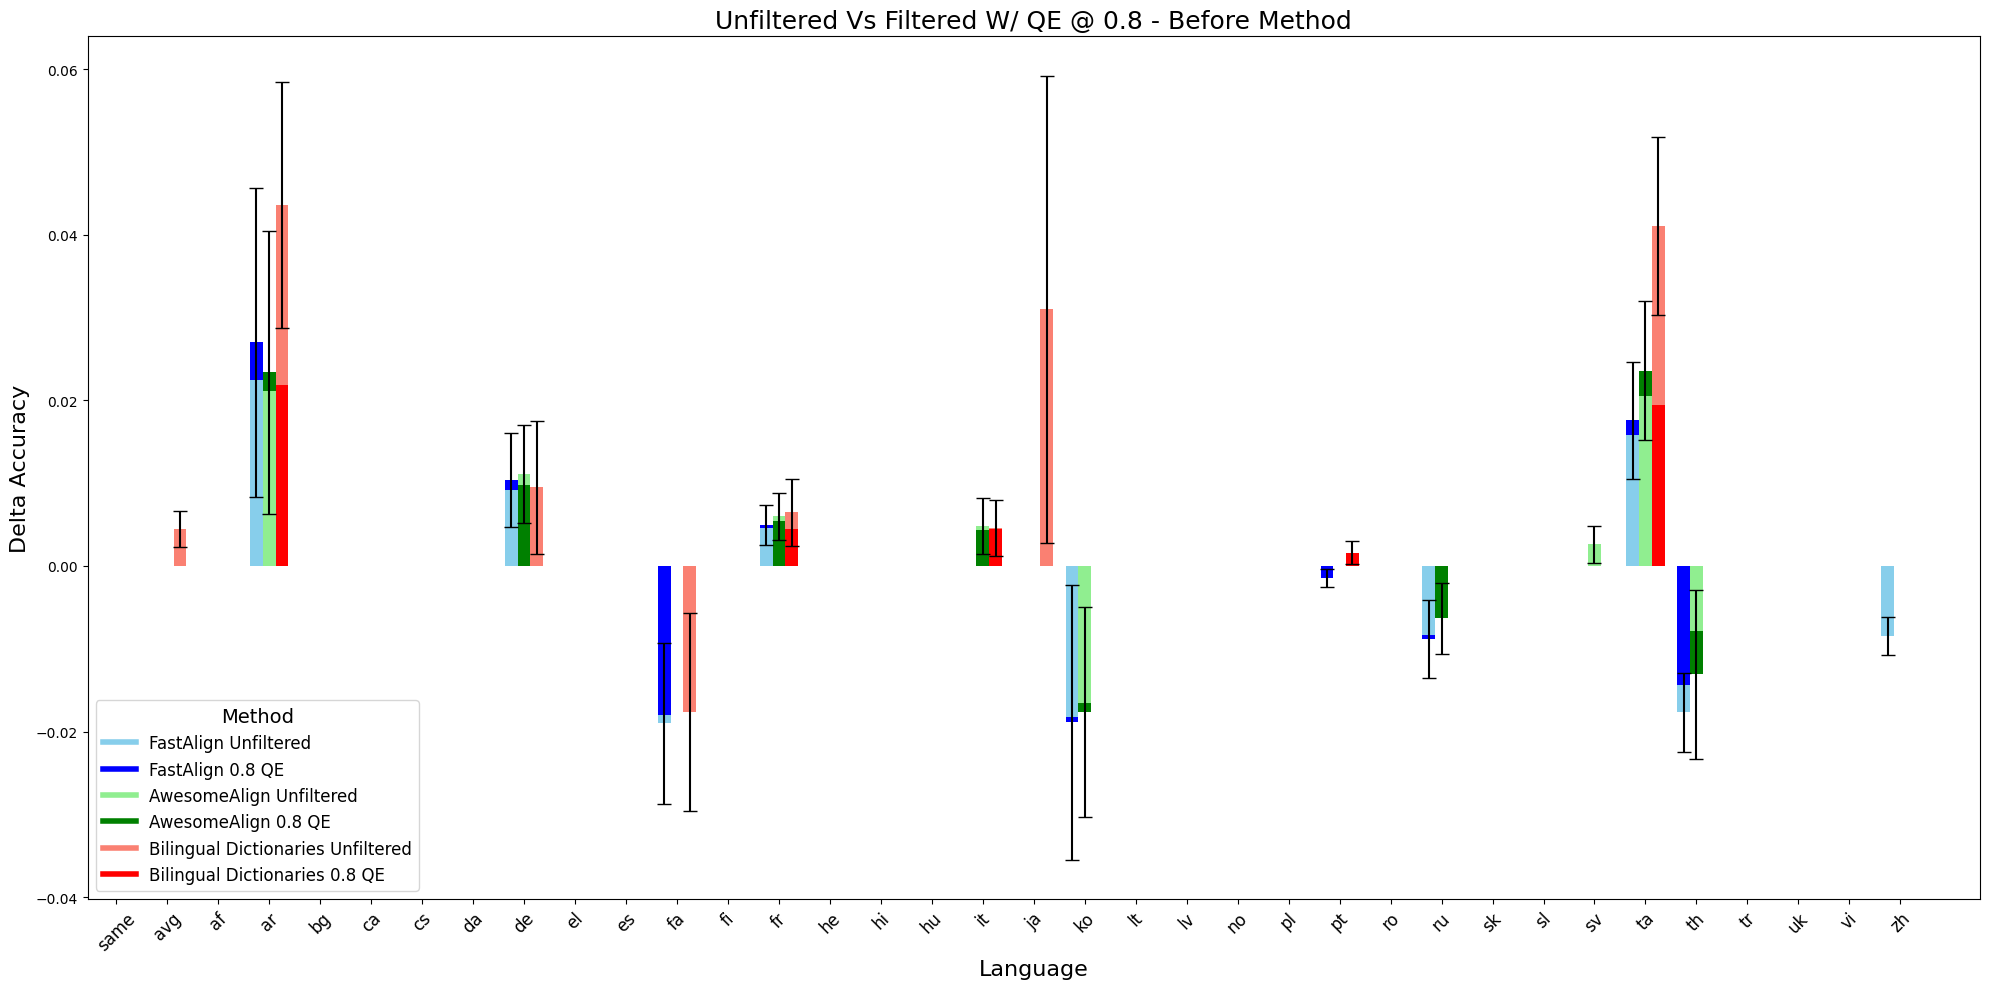

In [8]:
qe = 0.8

csv = f'./filtered_data/opus100_filtered_{qe}.csv'

project_pairs = [
    (("3nl_34langs_before_fastalign_udpos", None), (csv, "before_fastalign")),
    (("3nl_34langs_before_awesome_udpos", None), (csv, "before_awesome")),
    (("3nl_34langs_before_dico_udpos", None), (csv, "before_dico")),
]

show = True

plot_layered_bar_deltas(project_pairs, langs,
                        title=f'Unfiltered Vs Filtered W/ QE @ {qe} - Before Method',
                        show_error_bars=show, 
                        hide_bars_crossing_zero=show,
                        legend_suffixes=['Unfiltered', f'{qe} QE'])

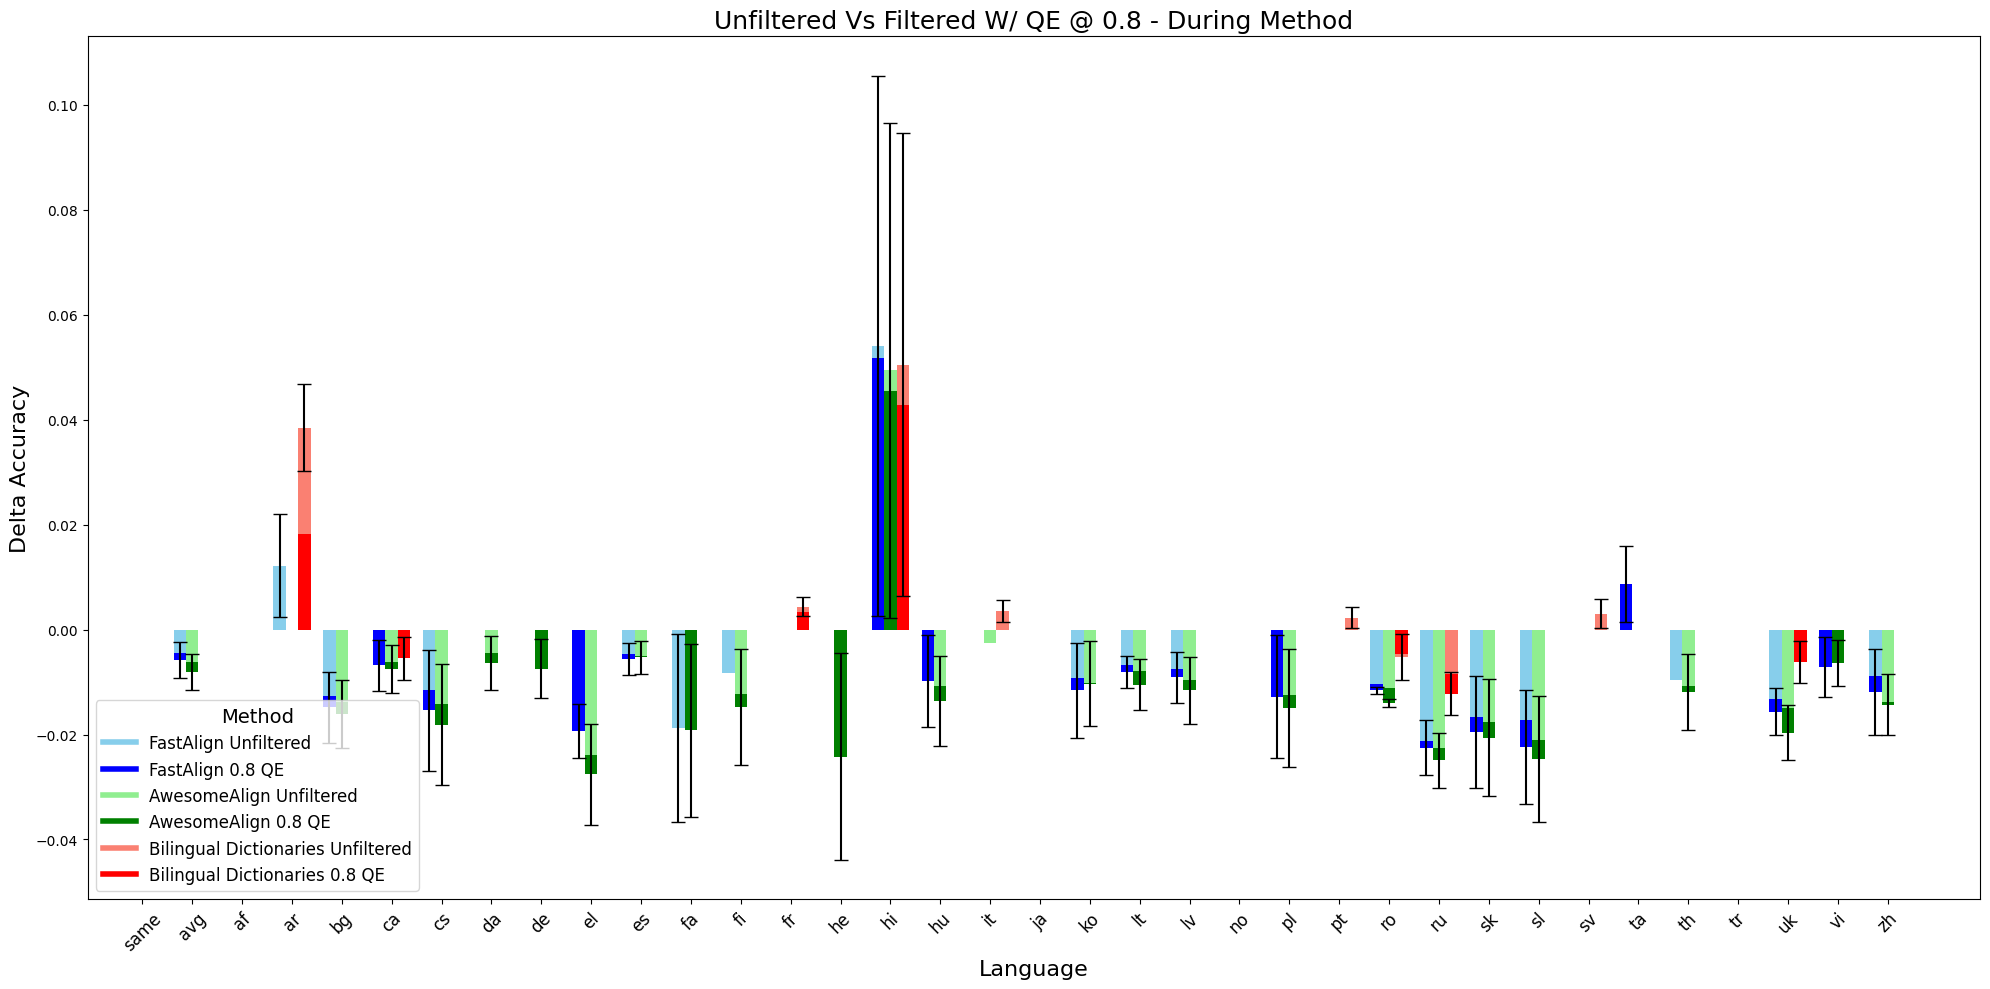

In [9]:
qe = 0.8

csv = f'./filtered_data/opus100_filtered_{qe}.csv'

project_pairs = [
    (("3nl_34langs_during_fastalign_udpos", None), (csv, "during_fastalign")),
    (("3nl_34langs_during_awesome_udpos", None), (csv, "during_awesome")),
    (("3nl_34langs_during_dico_udpos", None), (csv, "during_dico")),
]

show = True

plot_layered_bar_deltas(project_pairs, langs,
                        title=f'Unfiltered Vs Filtered W/ QE @ {qe} - During Method',
                        show_error_bars=show, 
                        hide_bars_crossing_zero=show,
                        legend_suffixes=['Unfiltered', f'{qe} QE'])

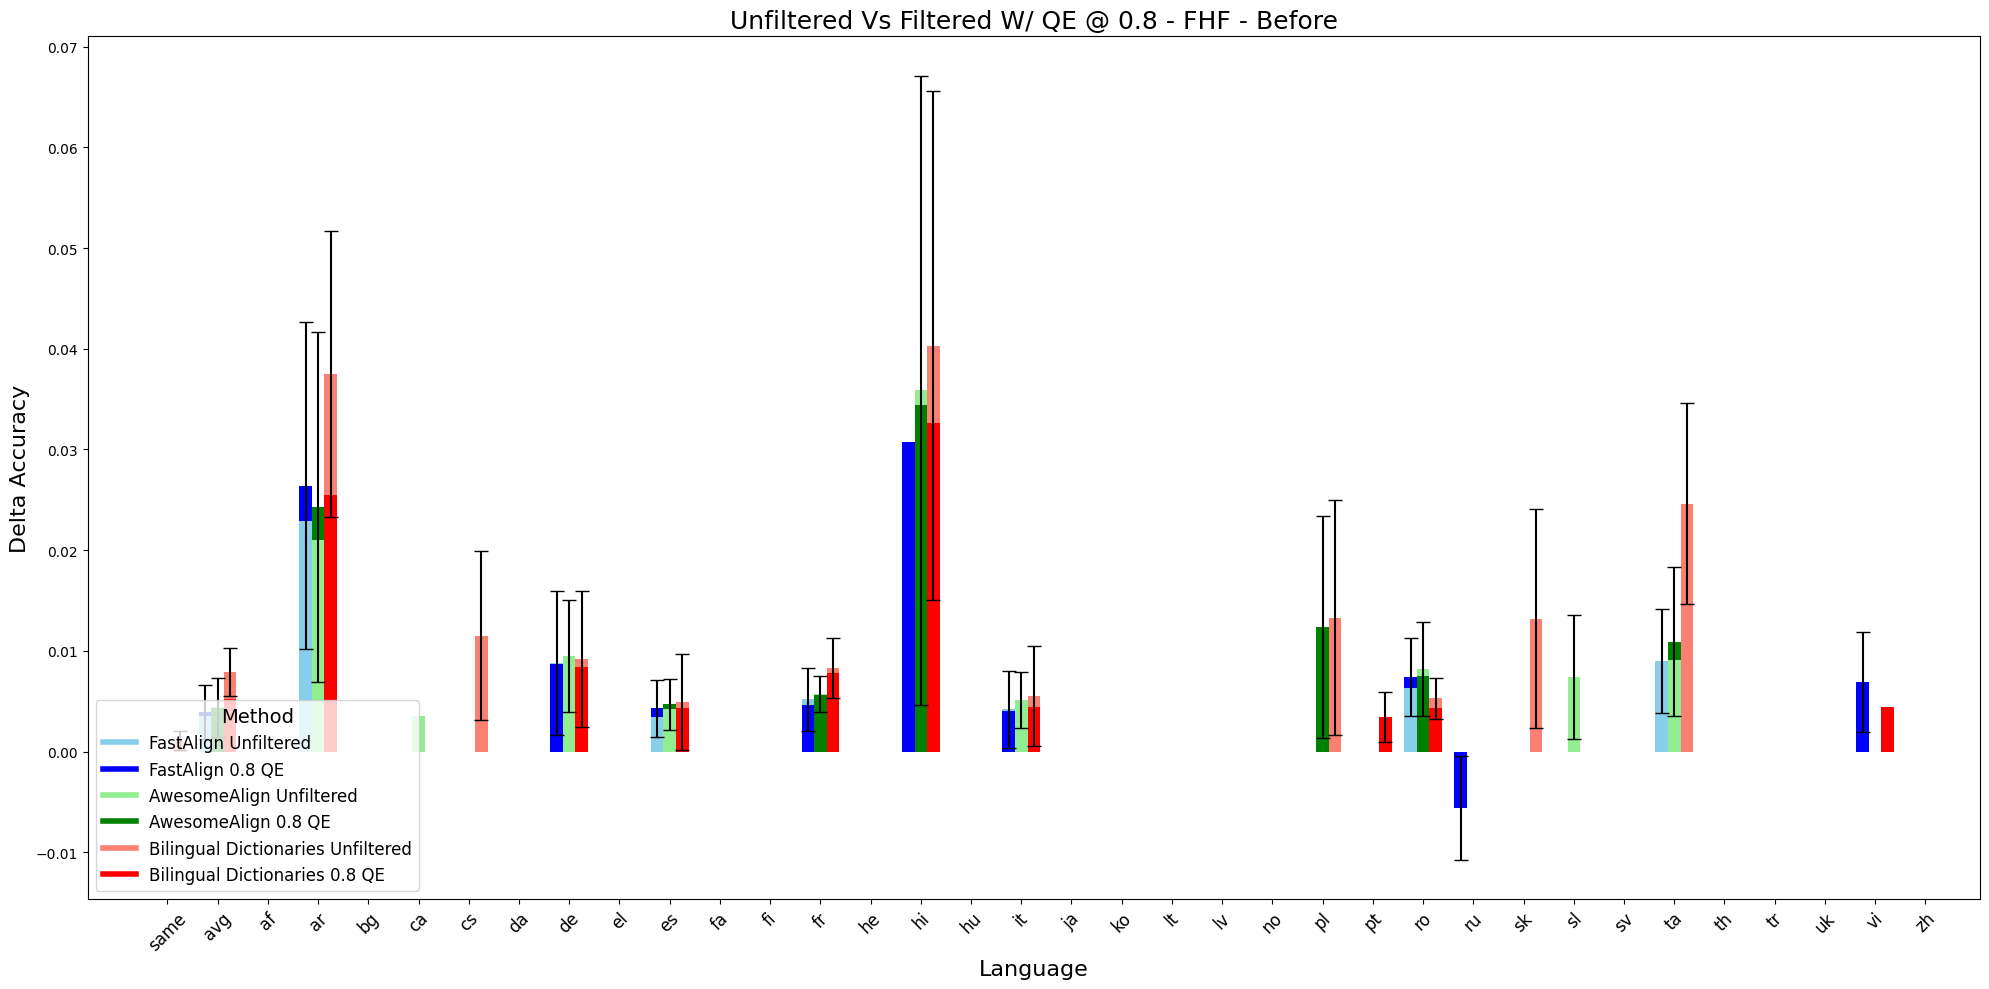

In [10]:
qe = 0.8

csv = f'./filtered_data/opus100_filtered_{qe}.csv'

project_pairs = [
    (("3nl_34langs_freeze_realign_unfreeze_fastalign_udpos", None), (csv, "freeze_realign_unfreeze_fastalign")),
    (("3nl_34langs_freeze_realign_unfreeze_awesome_udpos", None), (csv, "freeze_realign_unfreeze_awesome")),
    (("3nl_34langs_freeze_realign_unfreeze_dico_udpos", None), (csv, "freeze_realign_unfreeze_dico")),
]

show = True

plot_layered_bar_deltas(project_pairs, langs,
                        title=f'Unfiltered Vs Filtered W/ QE @ {qe} - FHF - Before',
                        show_error_bars=show, 
                        hide_bars_crossing_zero=show,
                        legend_suffixes=['Unfiltered', f'{qe} QE'])

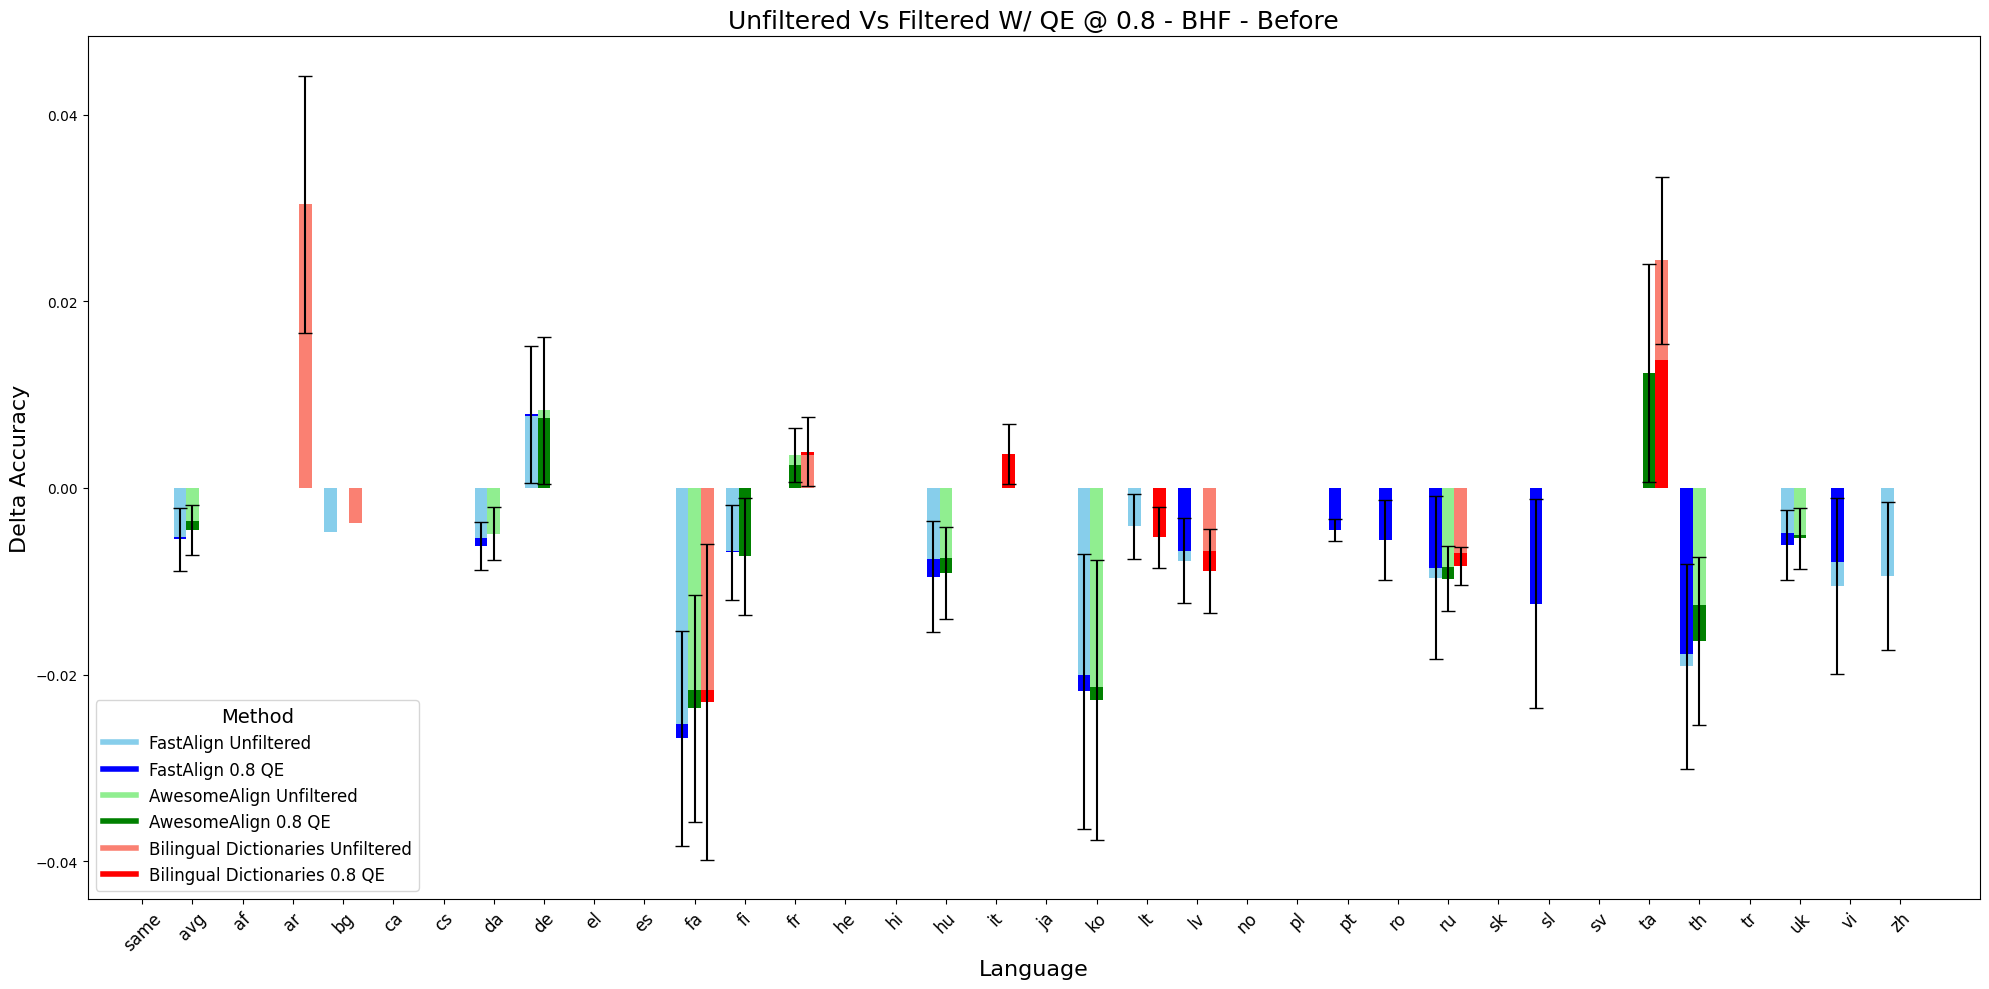

In [11]:
qe = 0.8

csv = f'./filtered_data/opus100_filtered_{qe}.csv'

project_pairs = [
    (("3nl_34langs_freeze_realign_unfreeze_last_6_fastalign_udpos", None), (csv, "freeze_realign_unfreeze_last_6_fastalign")),
    (("3nl_34langs_freeze_realign_unfreeze_last_6_awesome_udpos", None), (csv, "freeze_realign_unfreeze_last_6_awesome")),
    (("3nl_34langs_freeze_realign_unfreeze_last_6_dico_udpos", None), (csv, "freeze_realign_unfreeze_last_6_dico")),
]

show = True

plot_layered_bar_deltas(project_pairs, langs,
                        title=f'Unfiltered Vs Filtered W/ QE @ {qe} - BHF - Before',
                        show_error_bars=show, 
                        hide_bars_crossing_zero=show,
                        legend_suffixes=['Unfiltered', f'{qe} QE'])

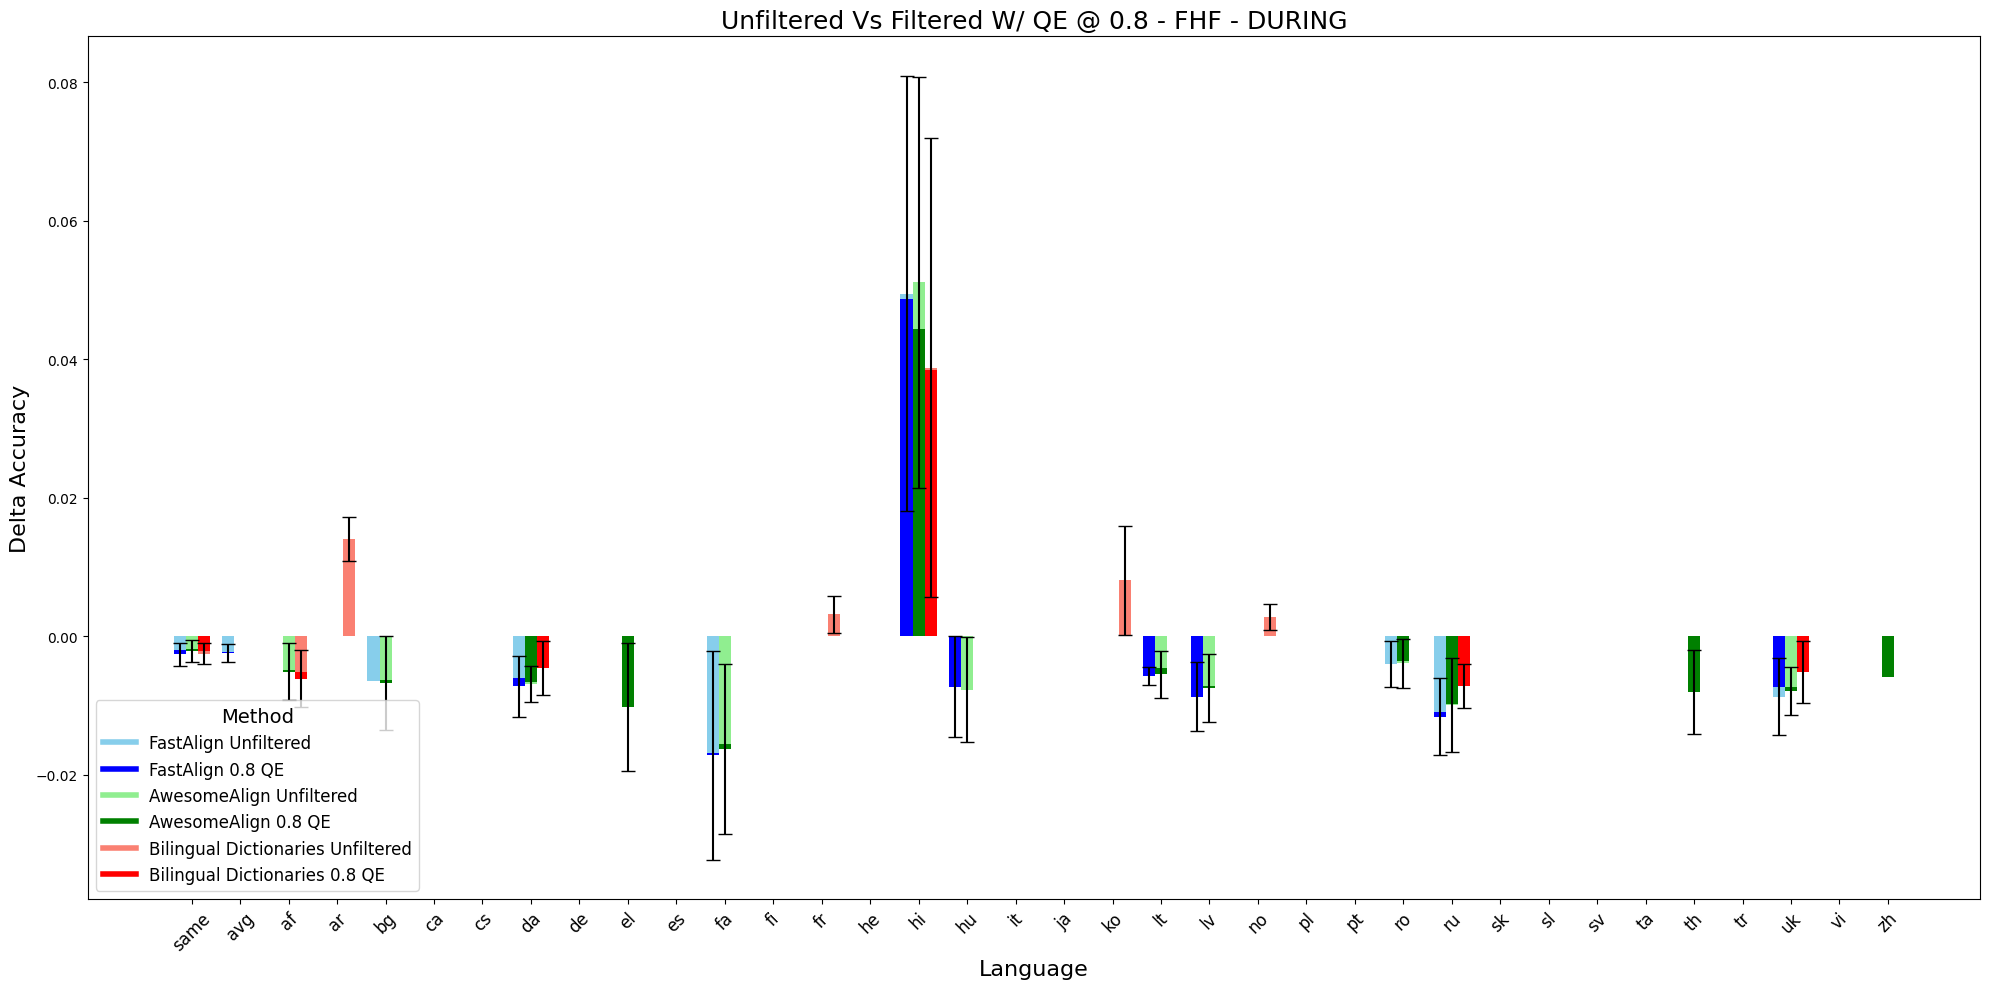

In [12]:
qe = 0.8

csv = f'./filtered_data/opus100_filtered_{qe}.csv'

project_pairs = [
    (("3nl_34langs_during_partial_freeze_front_fastalign_udpos", None), (csv, "during_partial_freeze_front_fastalign")),
    (("3nl_34langs_during_partial_freeze_front_awesome_udpos", None), (csv, "during_partial_freeze_front_awesome")),
    (("3nl_34langs_during_partial_freeze_front_dico_udpos", None), (csv, "during_partial_freeze_front_dico")),
]

show = True

plot_layered_bar_deltas(project_pairs, langs,
                        title=f'Unfiltered Vs Filtered W/ QE @ {qe} - FHF - DURING',
                        show_error_bars=show, 
                        hide_bars_crossing_zero=show,
                        legend_suffixes=['Unfiltered', f'{qe} QE'])

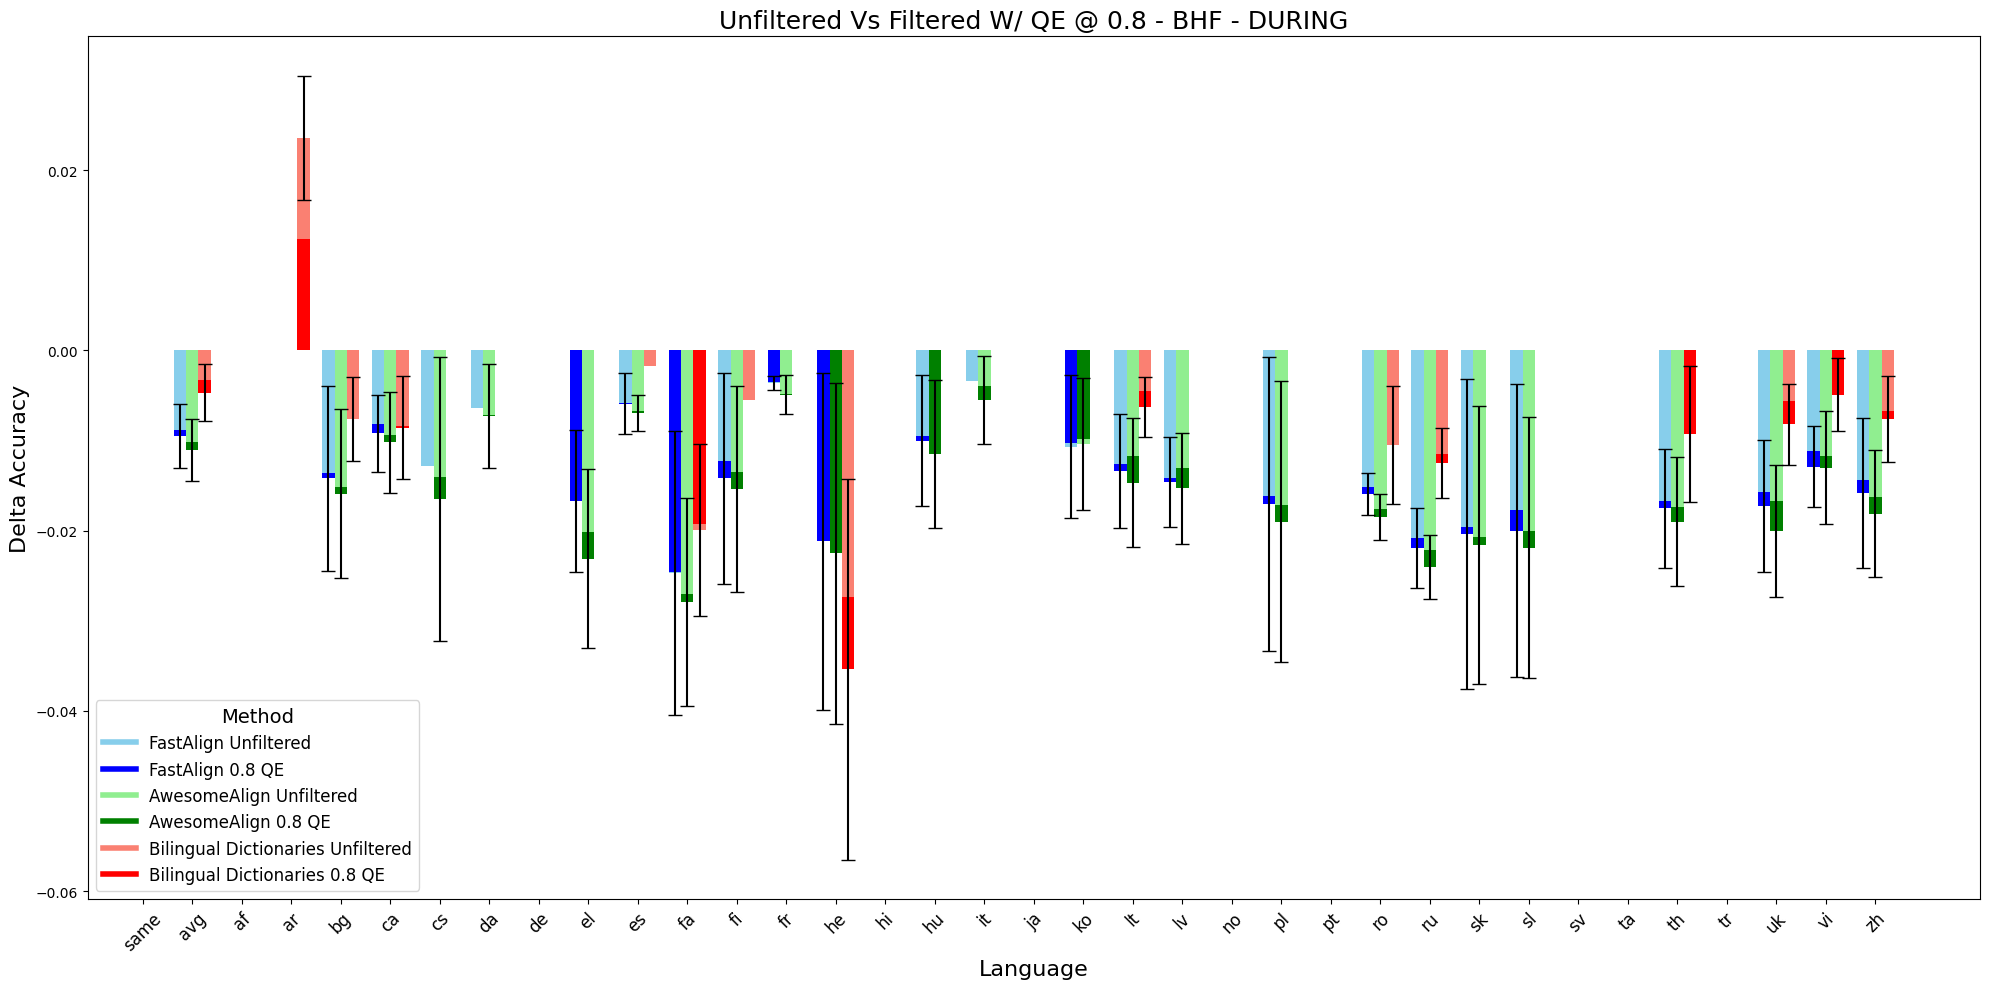

In [13]:
qe = 0.8

csv = f'./filtered_data/opus100_filtered_{qe}.csv'

project_pairs = [
    (("3nl_34langs_during_partial_freeze_back_fastalign_udpos", None), (csv, "during_partial_freeze_back_fastalign")),
    (("3nl_34langs_during_partial_freeze_back_awesome_udpos", None), (csv, "during_partial_freeze_back_awesome")),
    (("3nl_34langs_during_partial_freeze_back_dico_udpos", None), (csv, "during_partial_freeze_back_dico")),
]

show = True

plot_layered_bar_deltas(project_pairs, langs,
                        title=f'Unfiltered Vs Filtered W/ QE @ {qe} - BHF - DURING',
                        show_error_bars=show, 
                        hide_bars_crossing_zero=show,
                        legend_suffixes=['Unfiltered', f'{qe} QE'])

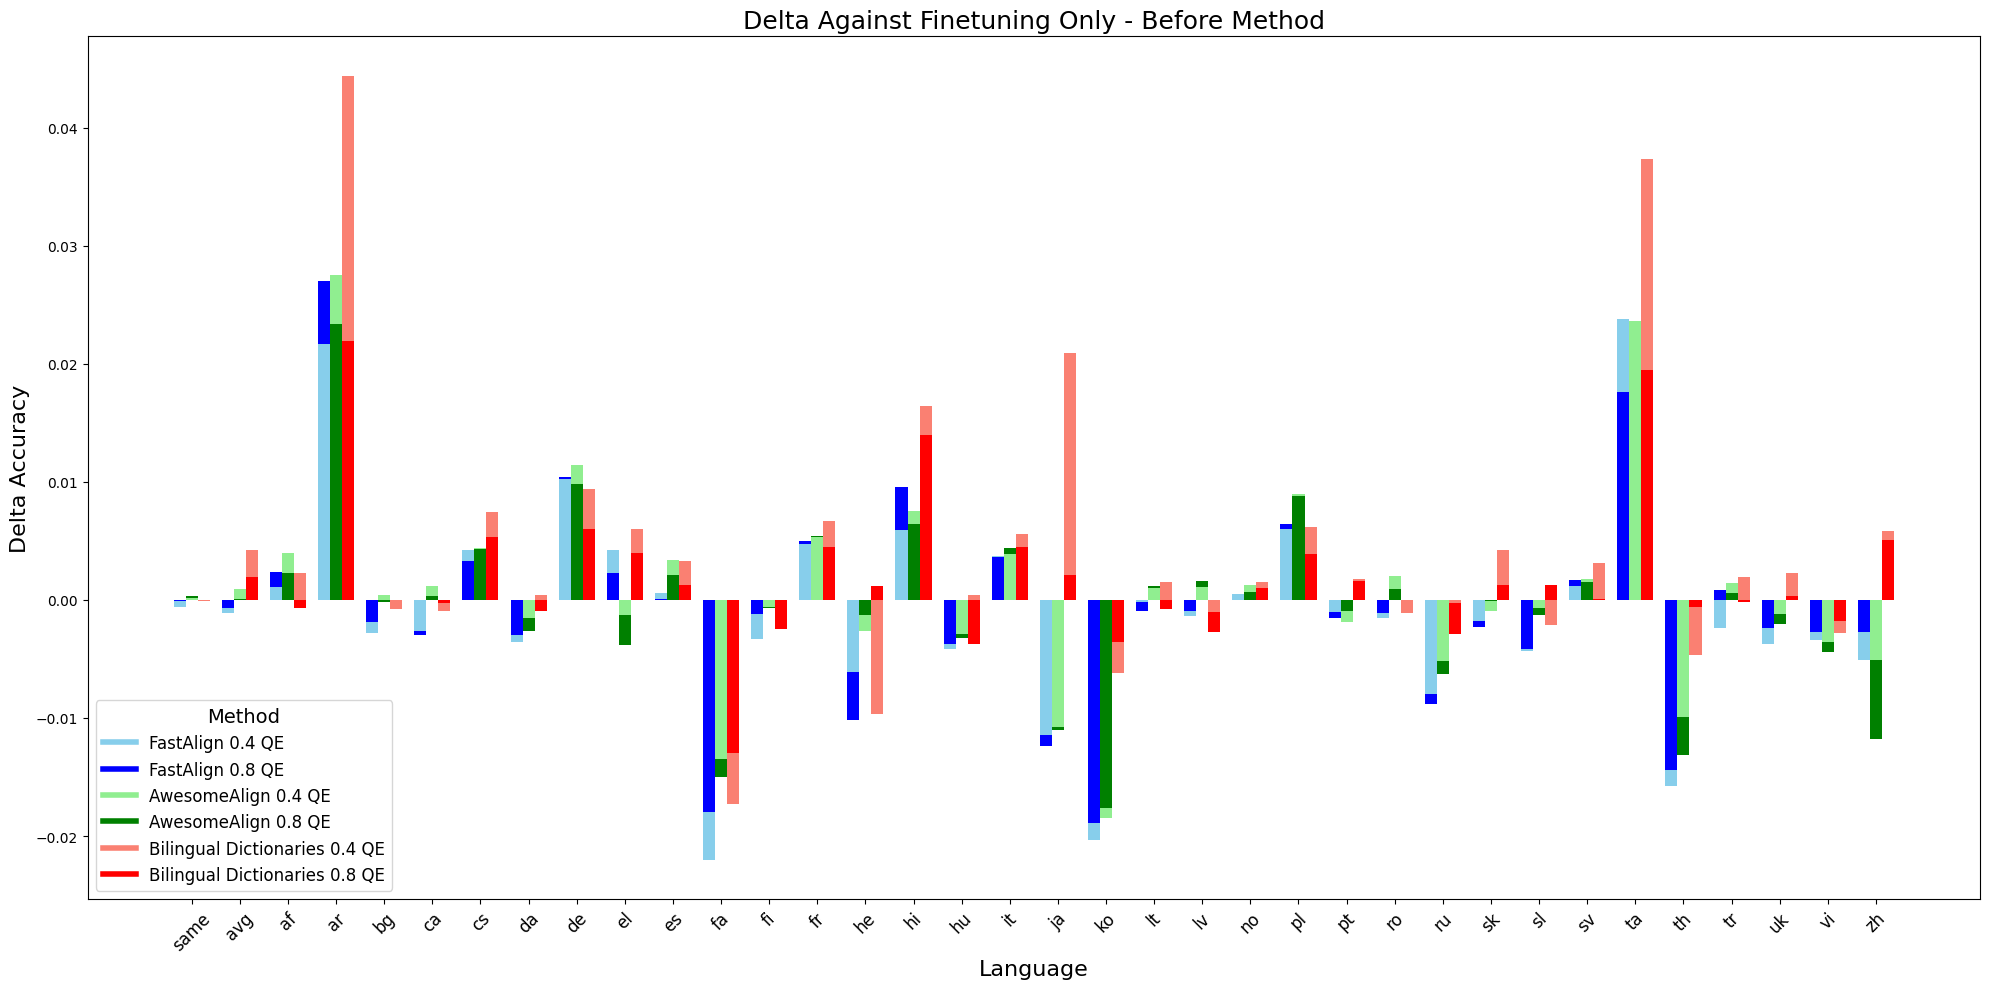

In [14]:


csv1 = './filtered_data/opus100_filtered_0.4.csv'
csv2 = './filtered_data/opus100_filtered_0.8.csv'

project_pairs = [
    ((csv1, "before_fastalign"), (csv2, "before_fastalign")),
    ((csv1, "before_awesome"), (csv2, "before_awesome")),
    ((csv1, "before_dico"), (csv2, "before_dico")),
]

show = False

plot_layered_bar_deltas(project_pairs, langs,
                        title='Delta Against Finetuning Only - Before Method',
                        show_error_bars=show, 
                        hide_bars_crossing_zero=show,
                        legend_suffixes=['0.4 QE', '0.8 QE'])

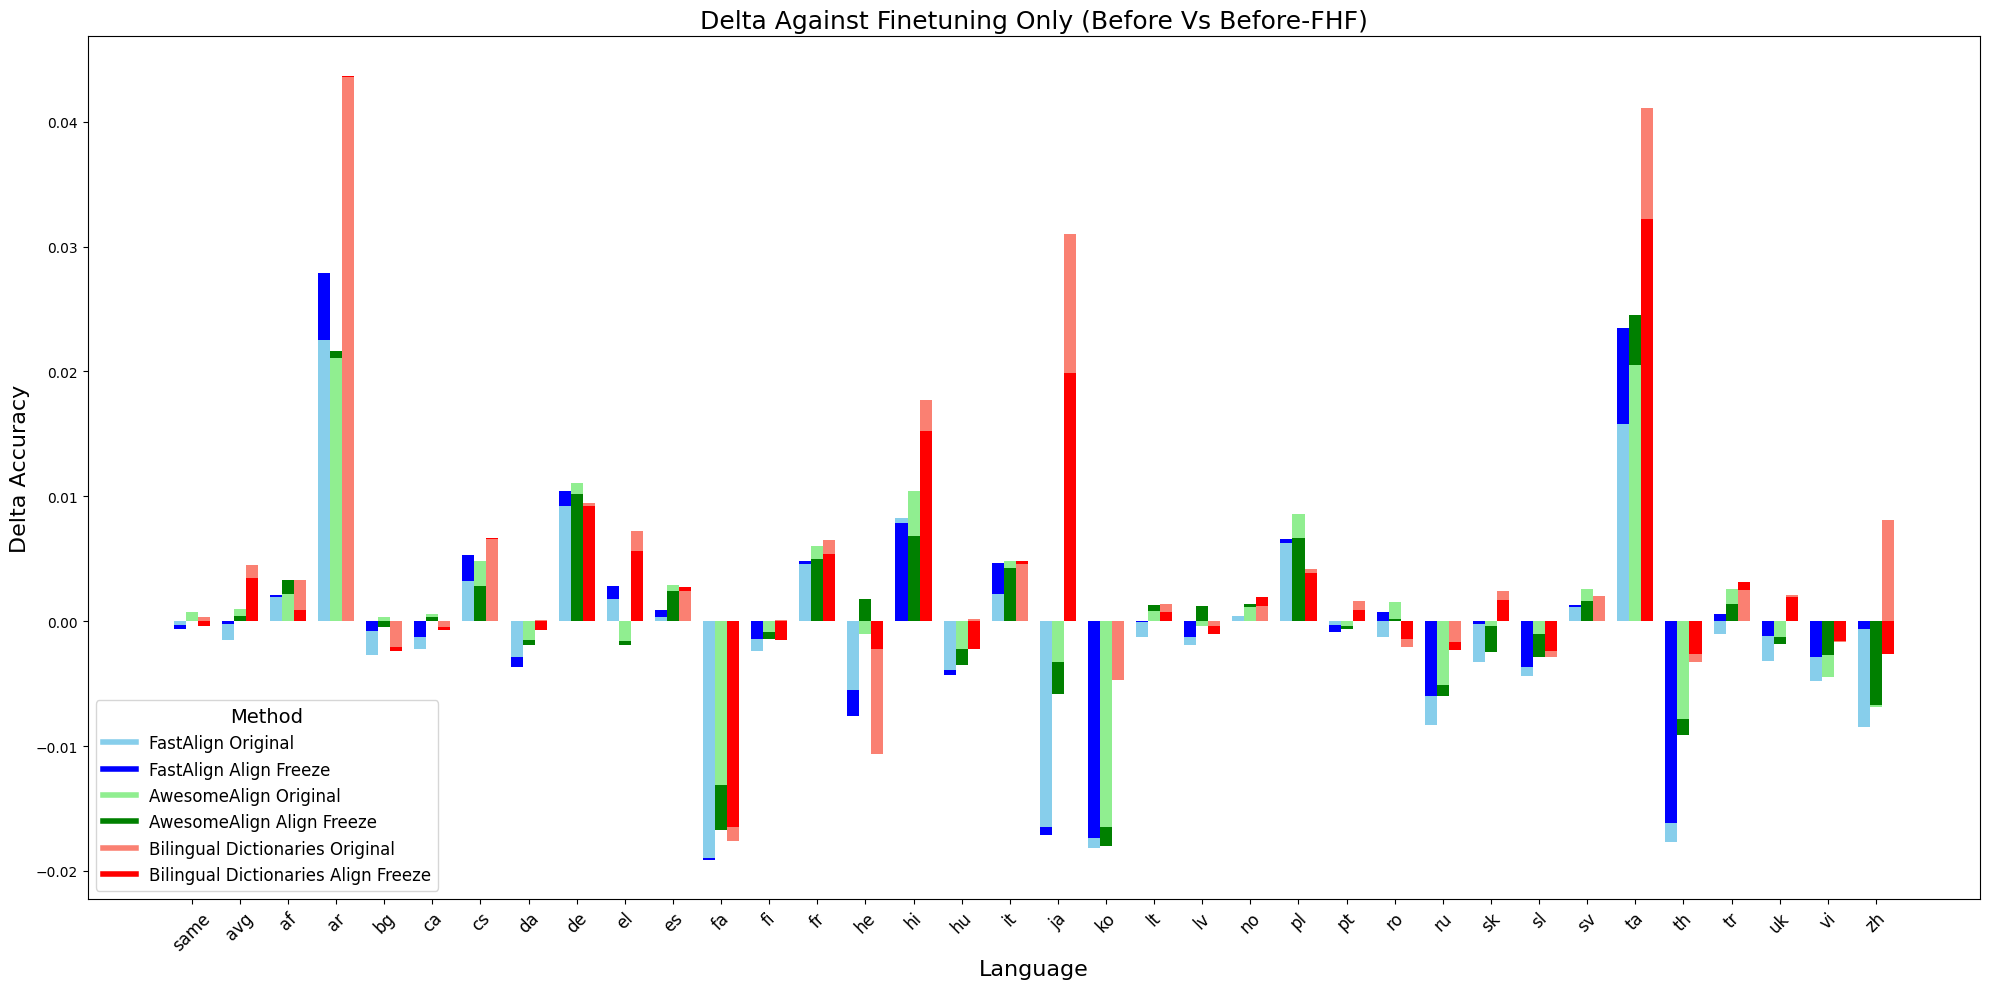

In [15]:
csv1 = './filtered_data/opus100_filtered_0.4.csv'
csv2 = './filtered_data/opus100_filtered_0.6.csv'

project_pairs = [
    (('3nl_34langs_before_fastalign_udpos', None), (csv2, "before_fastalign")),
    (('3nl_34langs_before_awesome_udpos', None), (csv2, "before_awesome")),
    (('3nl_34langs_before_dico_udpos', None), (csv2, "before_dico")),
]

show = False

plot_layered_bar_deltas(project_pairs, langs,
                        title='Delta Against Finetuning Only (Before Vs Before-FHF)',
                        show_error_bars=show, 
                        hide_bars_crossing_zero=show)

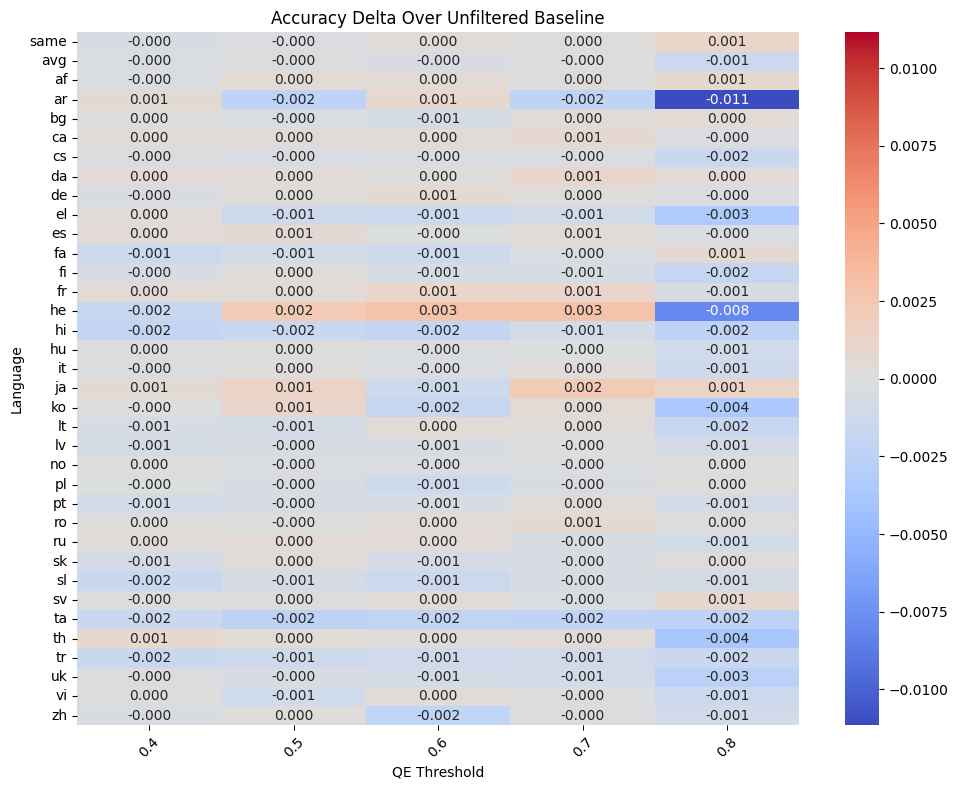

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def generate_heatmap_data(directory, baseline_data, method_name, langs, filter_steps):
    """Generate data structure for heatmap based on deltas between baseline and filtered data."""
    deltas = {lang: {f"{step}": None for step in filter_steps} for lang in langs}
    
    for step in filter_steps:
        csv_path = f"{directory}/opus100_filtered_{step}.csv"
        filtered_data = fetch_and_process_runs(csv_path, langs, method_name=method_name)
        for lang in langs:
            if lang in filtered_data and lang in baseline_data:
                delta = np.mean(filtered_data[lang]) - np.mean(baseline_data[lang])
                deltas[lang][f"{step}"] = delta
    
    return pd.DataFrame(deltas).T  

def plot_accuracy_deltas_heatmap(data, title="Accuracy Delta Over Unfiltered Baseline"):
    min_val = data.min().min()
    max_val = data.max().max()
    vmax = max(abs(min_val), abs(max_val))
    vmin = -vmax

    plt.figure(figsize=(10, 8))
    sns.heatmap(data, annot=True, cmap="coolwarm", center=0, fmt=".3f", vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.ylabel("Language")
    plt.xlabel("QE Threshold")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

directory = "./filtered_data"
method_name = "during_partial_freeze_back_dico"

baseline_project_name = f"3nl_34langs_{method_name}_udpos"
filter_steps = ["0.4", "0.5", "0.6", "0.7", "0.8"]  


baseline_data = fetch_and_process_runs(baseline_project_name, langs, method_name=None)


heatmap_data = generate_heatmap_data(directory, baseline_data, method_name, langs, filter_steps)


plot_accuracy_deltas_heatmap(heatmap_data)


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import t

def plot_layered_bar_deltas(project_pairs, _langs, finetuning_project_name, title=None, show_error_bars=False, hide_bars_crossing_zero=False,):
    aligners = ['FastAlign', 'AwesomeAlign', 'Bilingual Dictionaries']
    all_delta_data = []

    
    finetuning_data = fetch_and_process_runs(finetuning_project_name, _langs)

    for projects, aligner in zip(project_pairs, aligners):
        baseline_project, align_freeze_project = projects
        original_data = fetch_and_process_runs(baseline_project, _langs)
        align_freeze_data = fetch_and_process_runs(align_freeze_project, _langs)

        
        for lang in _langs:
            original_deltas = [baseline - finetuning for finetuning, baseline in zip(finetuning_data[lang], original_data[lang])]
            align_freeze_deltas = [align_freeze - finetuning for finetuning, align_freeze in zip(finetuning_data[lang], align_freeze_data[lang])]

            original_delta_mean = np.mean(original_deltas)
            align_freeze_delta_mean = np.mean(align_freeze_deltas)
            
            
            original_delta_se = np.std(original_deltas, ddof=1) / np.sqrt(len(original_deltas))
            align_freeze_delta_se = np.std(align_freeze_deltas, ddof=1) / np.sqrt(len(align_freeze_deltas))

            
            t_score_original = t.ppf(0.975, df=len(original_deltas)-1)  
            t_score_align_freeze = t.ppf(0.975, df=len(align_freeze_deltas)-1)

            
            original_delta_margin = t_score_original * original_delta_se
            align_freeze_delta_margin = t_score_align_freeze * align_freeze_delta_se

            all_delta_data.append({'Language': lang, 'Mean Delta': original_delta_mean, 'CI Margin': original_delta_margin, 'Method': f'{aligner} Original', 'Aligner': aligner})
            all_delta_data.append({'Language': lang, 'Mean Delta': align_freeze_delta_mean, 'CI Margin': align_freeze_delta_margin, 'Method': f'{aligner} Align Freeze', 'Aligner': aligner})

    
    combined_df = pd.DataFrame(all_delta_data)
    combined_df['Aligner'] = pd.Categorical(combined_df['Aligner'], categories=aligners, ordered=True)
    combined_df['Language'] = pd.Categorical(combined_df['Language'], categories=['same', 'avg'] + sorted(set(_langs) - set(['same', 'avg'])), ordered=True)
    combined_df.sort_values(by=['Language', 'Aligner', 'Method'], inplace=True)

    
    plt.figure(figsize=(20, 10))
    width = 0.25  
    colors = {
        'FastAlign Original': 'skyblue', 
        'FastAlign Align Freeze': 'blue', 
        'AwesomeAlign Original': 'lightgreen', 
        'AwesomeAlign Align Freeze': 'green',
        'Bilingual Dictionaries Original': 'salmon', 
        'Bilingual Dictionaries Align Freeze': 'red'
    }

    
    def ci_crosses_zero(delta, ci_margin):
        return delta - ci_margin <= 0 <= delta + ci_margin

    
    def plot_bar(position, delta, ci_margin, color, method, with_error_bars, hide_bars_crossing_zero):
        
        if hide_bars_crossing_zero and ci_crosses_zero(delta, ci_margin):
            return

        if not show_error_bars:
            with_error_bars = False

        
        plt.bar(position, delta, width, color=color, label=method, yerr=ci_margin if with_error_bars else None, capsize=5 if with_error_bars else None)

    
    for i, aligner in enumerate(aligners):
        for j, lang in enumerate(combined_df['Language'].unique()):
            
            original_method_label = f'{aligner} Original'
            alignfreeze_method_label = f'{aligner} Align Freeze'

            
            original_data = combined_df[(combined_df['Language'] == lang) & (combined_df['Method'] == original_method_label)]
            alignfreeze_data = combined_df[(combined_df['Language'] == lang) & (combined_df['Method'] == alignfreeze_method_label)]

            
            original_delta = round(original_data['Mean Delta'].values[0], 4)
            alignfreeze_delta = round(alignfreeze_data['Mean Delta'].values[0], 4)
            original_ci_margin = original_data['CI Margin'].values[0]
            alignfreeze_ci_margin = alignfreeze_data['CI Margin'].values[0]

            
            position = j + (i - 1) * width

            
            larger_method_is_original = abs(original_delta) > abs(alignfreeze_delta)

            
            if larger_method_is_original:
                plot_bar(position, original_delta, original_ci_margin, colors[original_method_label], original_method_label, True, hide_bars_crossing_zero)
                plot_bar(position, alignfreeze_delta, alignfreeze_ci_margin, colors[alignfreeze_method_label], alignfreeze_method_label, False, hide_bars_crossing_zero)
            else:
                plot_bar(position, alignfreeze_delta, alignfreeze_ci_margin, colors[alignfreeze_method_label], alignfreeze_method_label, True, hide_bars_crossing_zero)
                plot_bar(position, original_delta, original_ci_margin, colors[original_method_label], original_method_label, False, hide_bars_crossing_zero)

    
    plt.xticks(np.arange(len(combined_df['Language'].unique())), combined_df['Language'].unique(), rotation=45, fontsize=12)

    
    plt.xlabel('Language', fontsize=16)
    plt.ylabel('Delta Accuracy (%)', fontsize=16)  
    plt.title(title if title else "Delta Accuracy (Original Vs Align Freeze)", fontsize=18)

    
    legend_handles = []
    for aligner in aligners:
        legend_handles.append(plt.Line2D([0], [0], color=colors[f'{aligner} Original'], lw=4, label=f'{aligner} Original'))
        legend_handles.append(plt.Line2D([0], [0], color=colors[f'{aligner} Align Freeze'], lw=4, label=f'{aligner} Align Freeze'))

    
    plt.legend(handles=legend_handles, title="Method", fontsize=12, title_fontsize=14, loc='upper left')

    plt.tight_layout()
    plt.show()


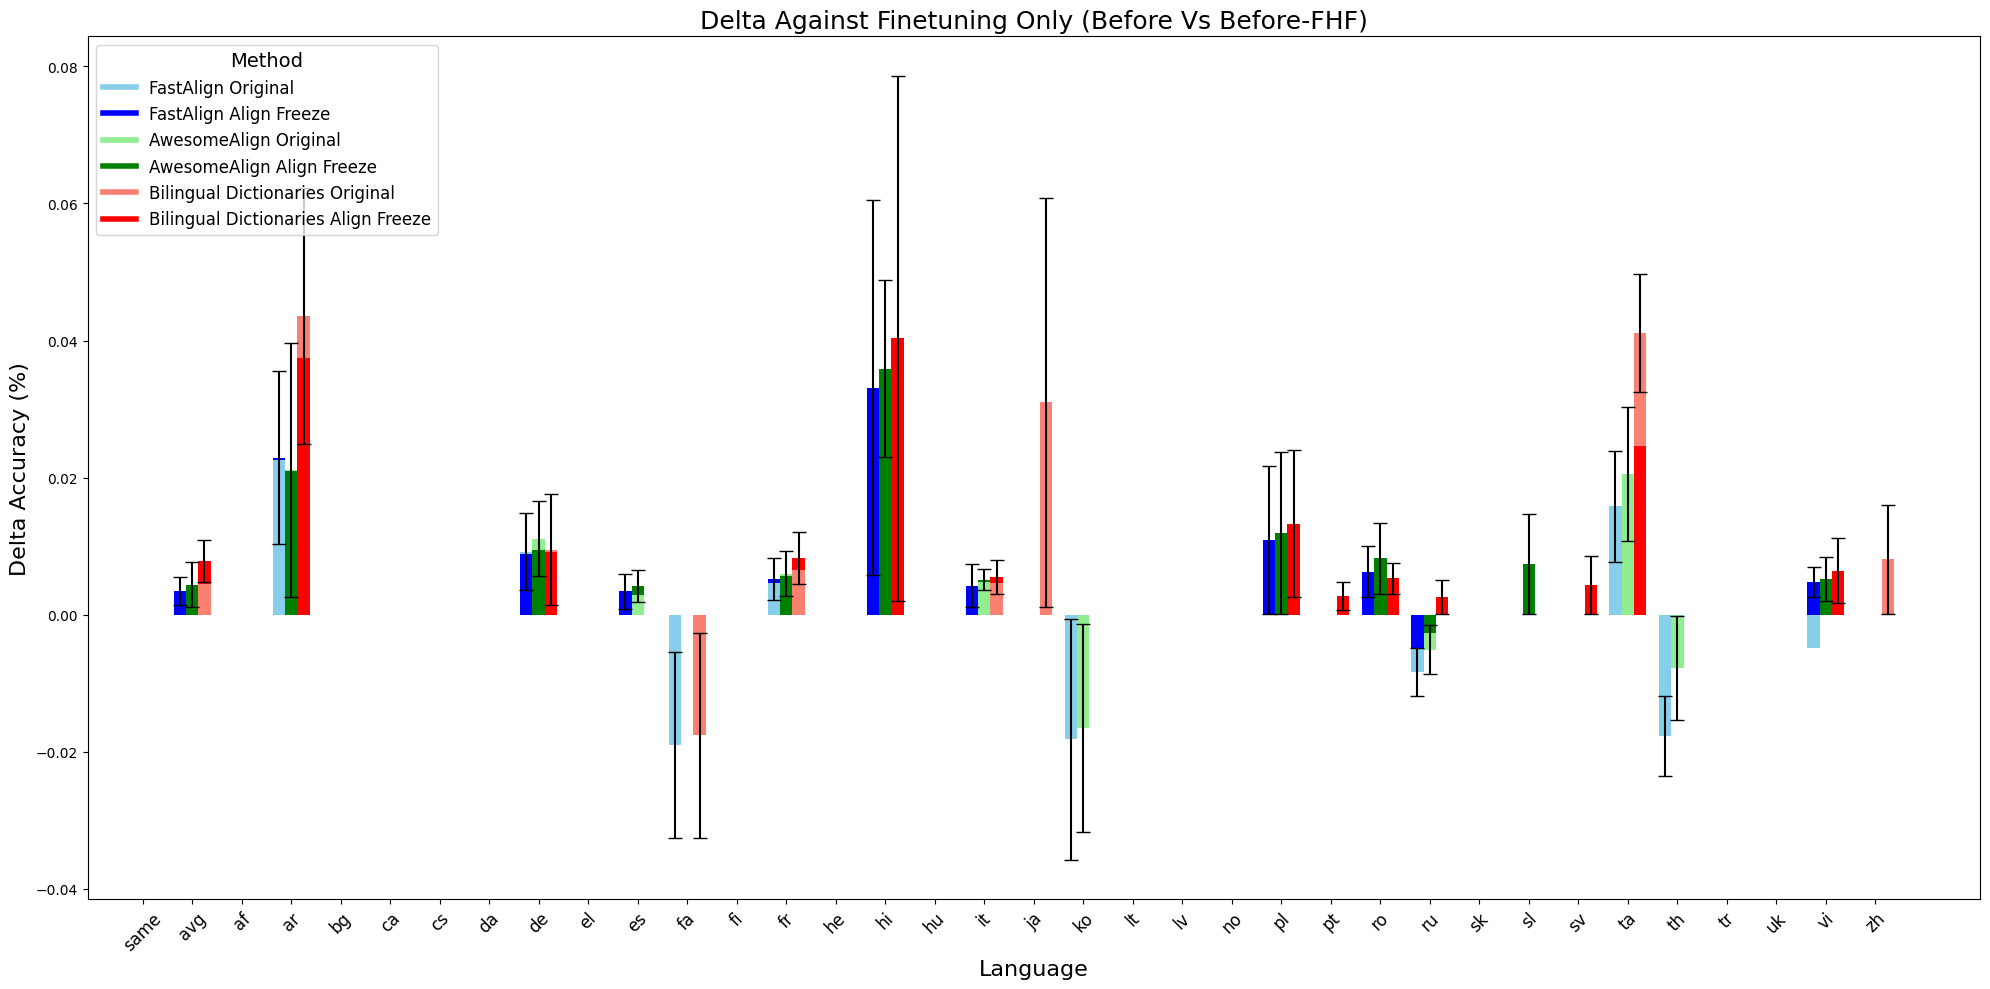

In [18]:

project_pairs = [
    ("3nl_34langs_before_fastalign_udpos", "3nl_34langs_freeze_realign_unfreeze_fastalign_udpos"),
    ("3nl_34langs_before_awesome_udpos", "3nl_34langs_freeze_realign_unfreeze_awesome_udpos"),
    ("3nl_34langs_before_dico_udpos", "3nl_34langs_freeze_realign_unfreeze_dico_udpos"),
]

show = True

plot_layered_bar_deltas(project_pairs, langs, finetuning_project_name=finetuning_project_name, 
                        title='Delta Against Finetuning Only (Before Vs Before-FHF)',
                        show_error_bars=show, 
                        hide_bars_crossing_zero=show)

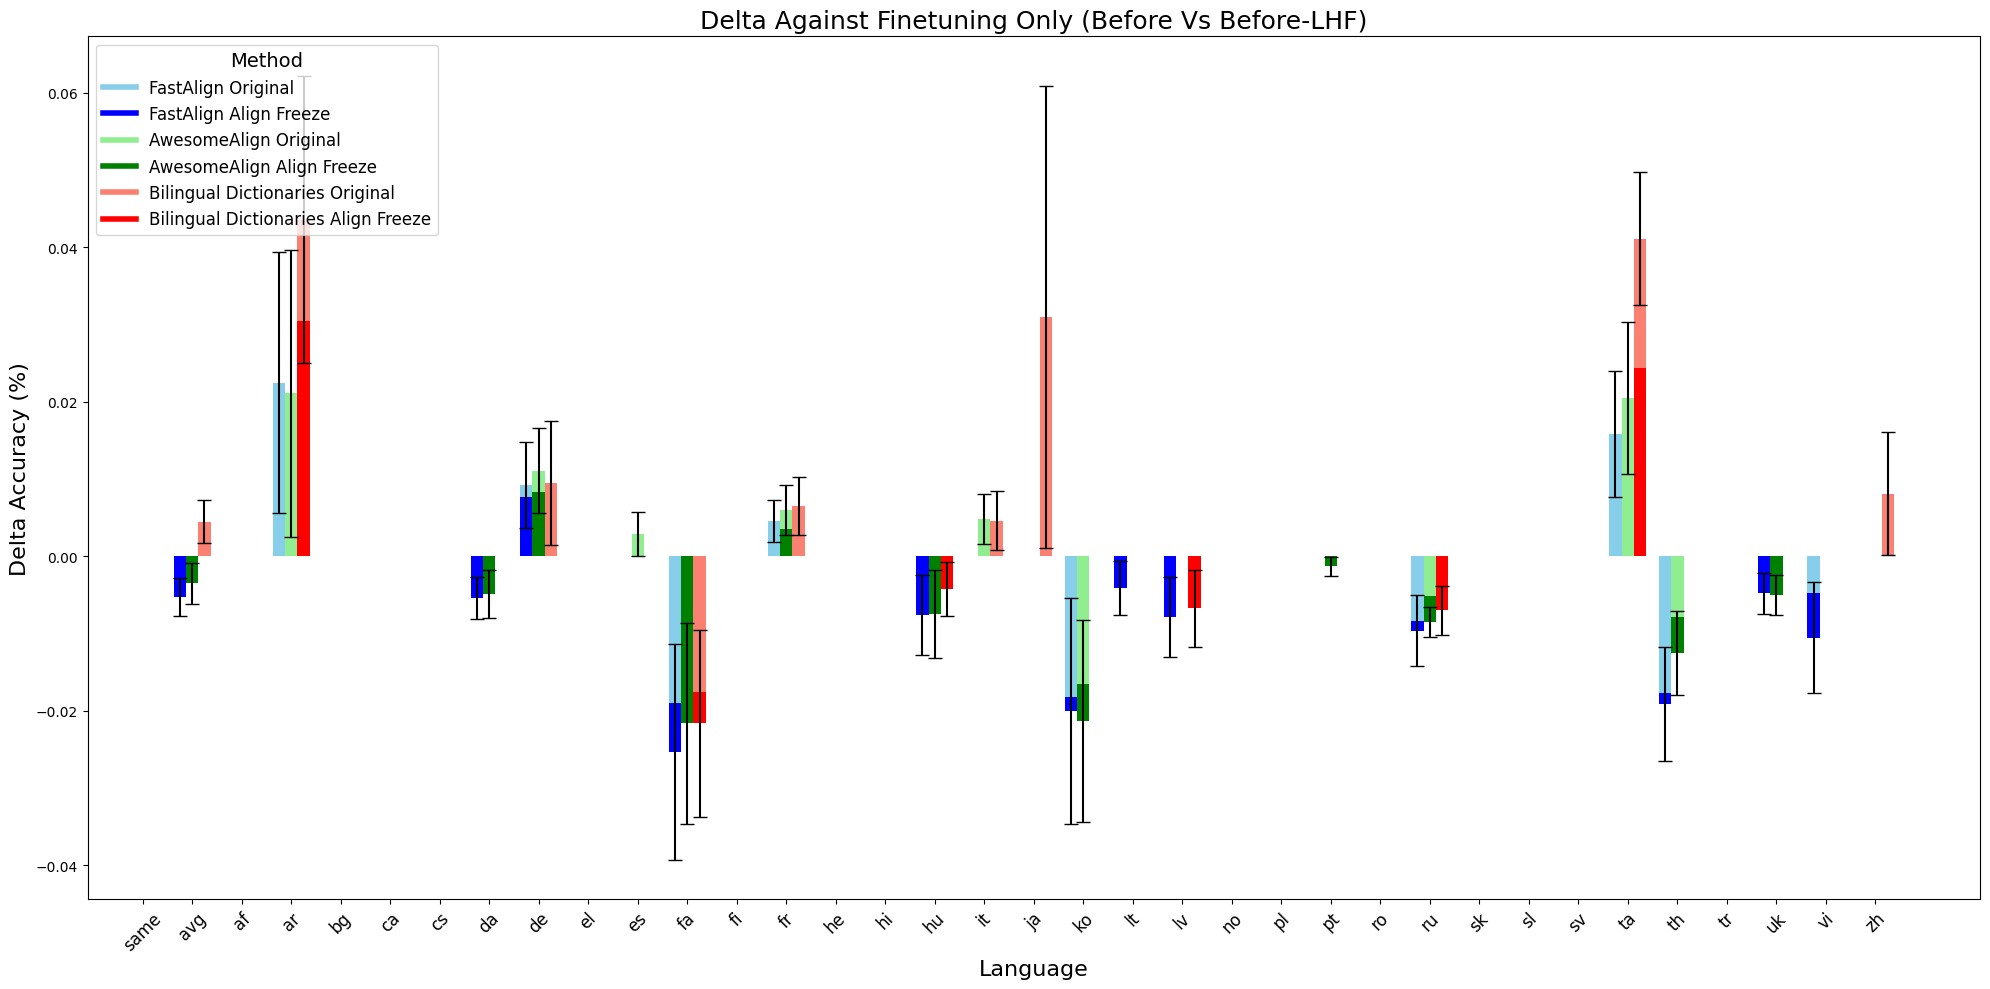

In [19]:

project_pairs = [
    ("3nl_34langs_before_fastalign_udpos", "3nl_34langs_freeze_realign_unfreeze_last_6_fastalign_udpos"),
    ("3nl_34langs_before_awesome_udpos", "3nl_34langs_freeze_realign_unfreeze_last_6_awesome_udpos"),
    ("3nl_34langs_before_dico_udpos", "3nl_34langs_freeze_realign_unfreeze_last_6_dico_udpos"),
]

show = True

plot_layered_bar_deltas(project_pairs, langs, finetuning_project_name=finetuning_project_name, 
                        title='Delta Against Finetuning Only (Before Vs Before-LHF)',
                        show_error_bars=show, 
                        hide_bars_crossing_zero=show)

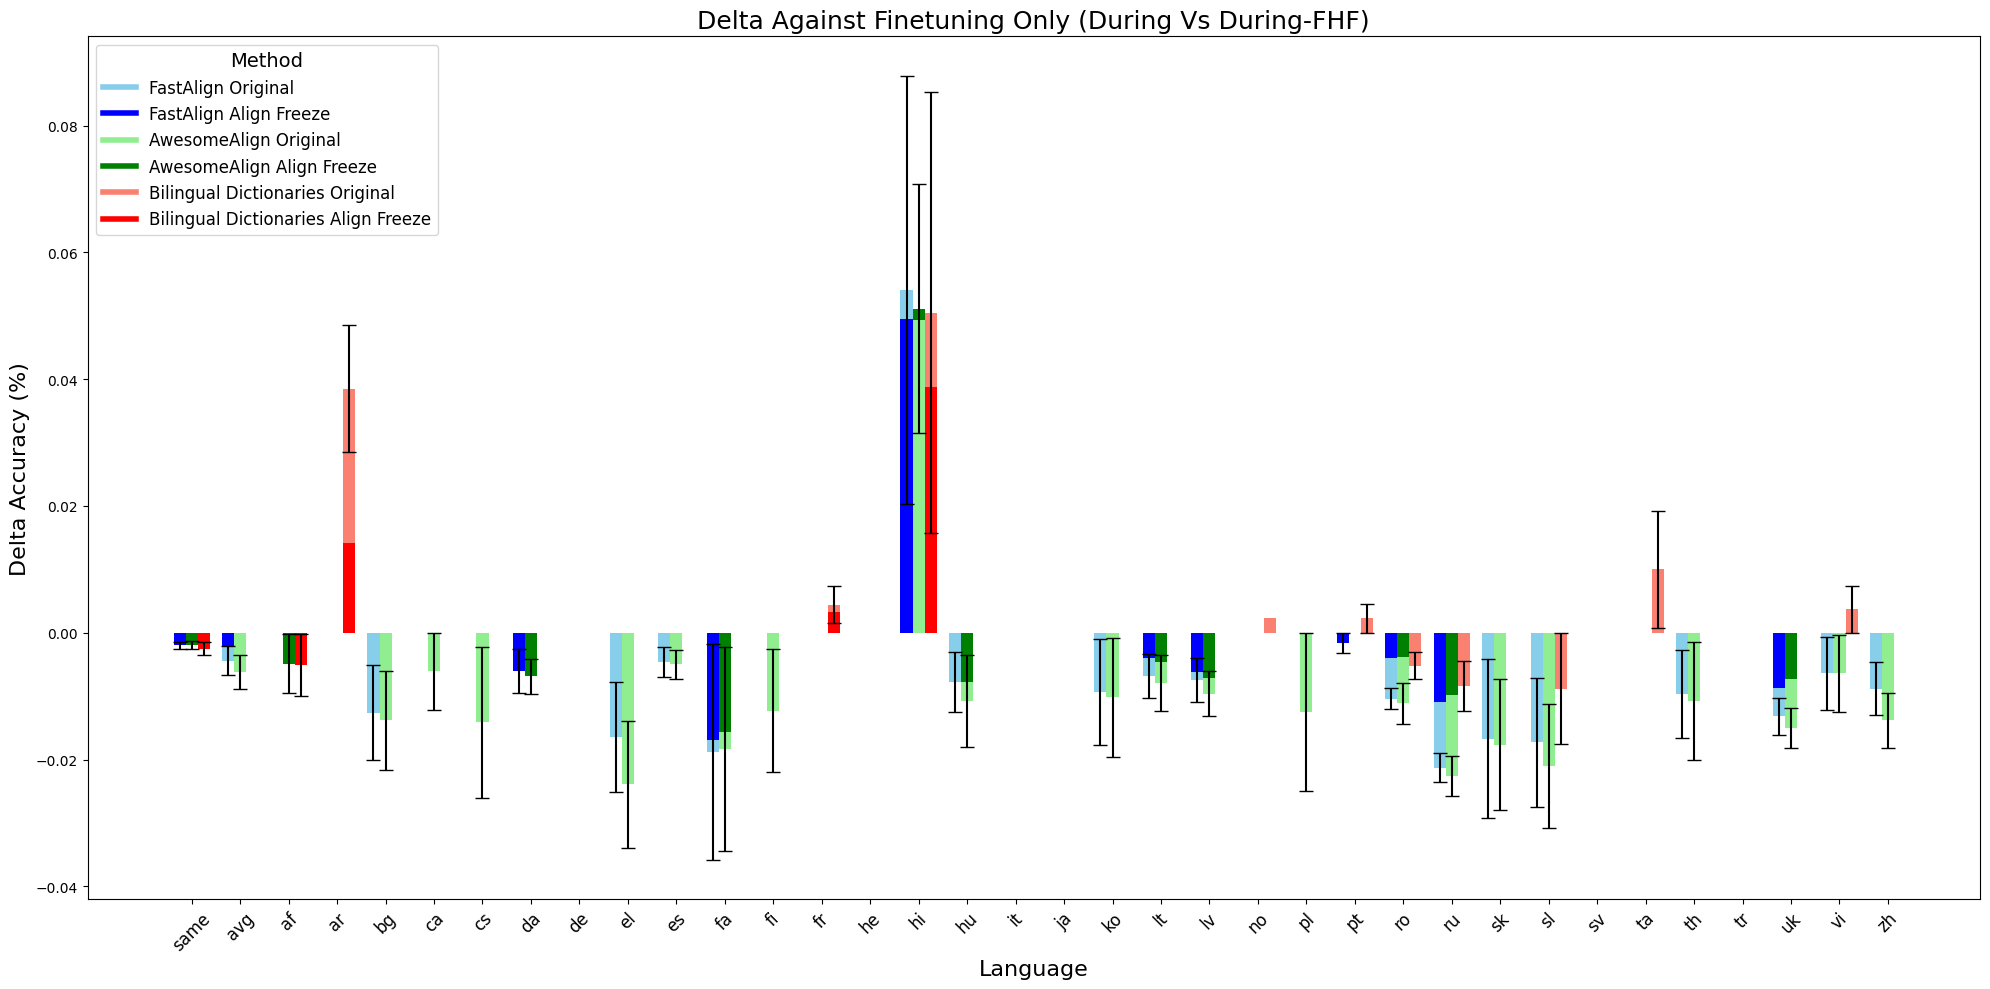

In [20]:
project_pairs = [
    ("3nl_34langs_during_fastalign_udpos", "3nl_34langs_during_partial_freeze_front_fastalign_udpos"),
    ("3nl_34langs_during_awesome_udpos", "3nl_34langs_during_partial_freeze_front_awesome_udpos"),
    ("3nl_34langs_during_dico_udpos", "3nl_34langs_during_partial_freeze_front_dico_udpos"),
]

show = True

plot_layered_bar_deltas(project_pairs, langs, finetuning_project_name=finetuning_project_name, 
                        title='Delta Against Finetuning Only (During Vs During-FHF)',
                        show_error_bars=show, 
                        hide_bars_crossing_zero=show)

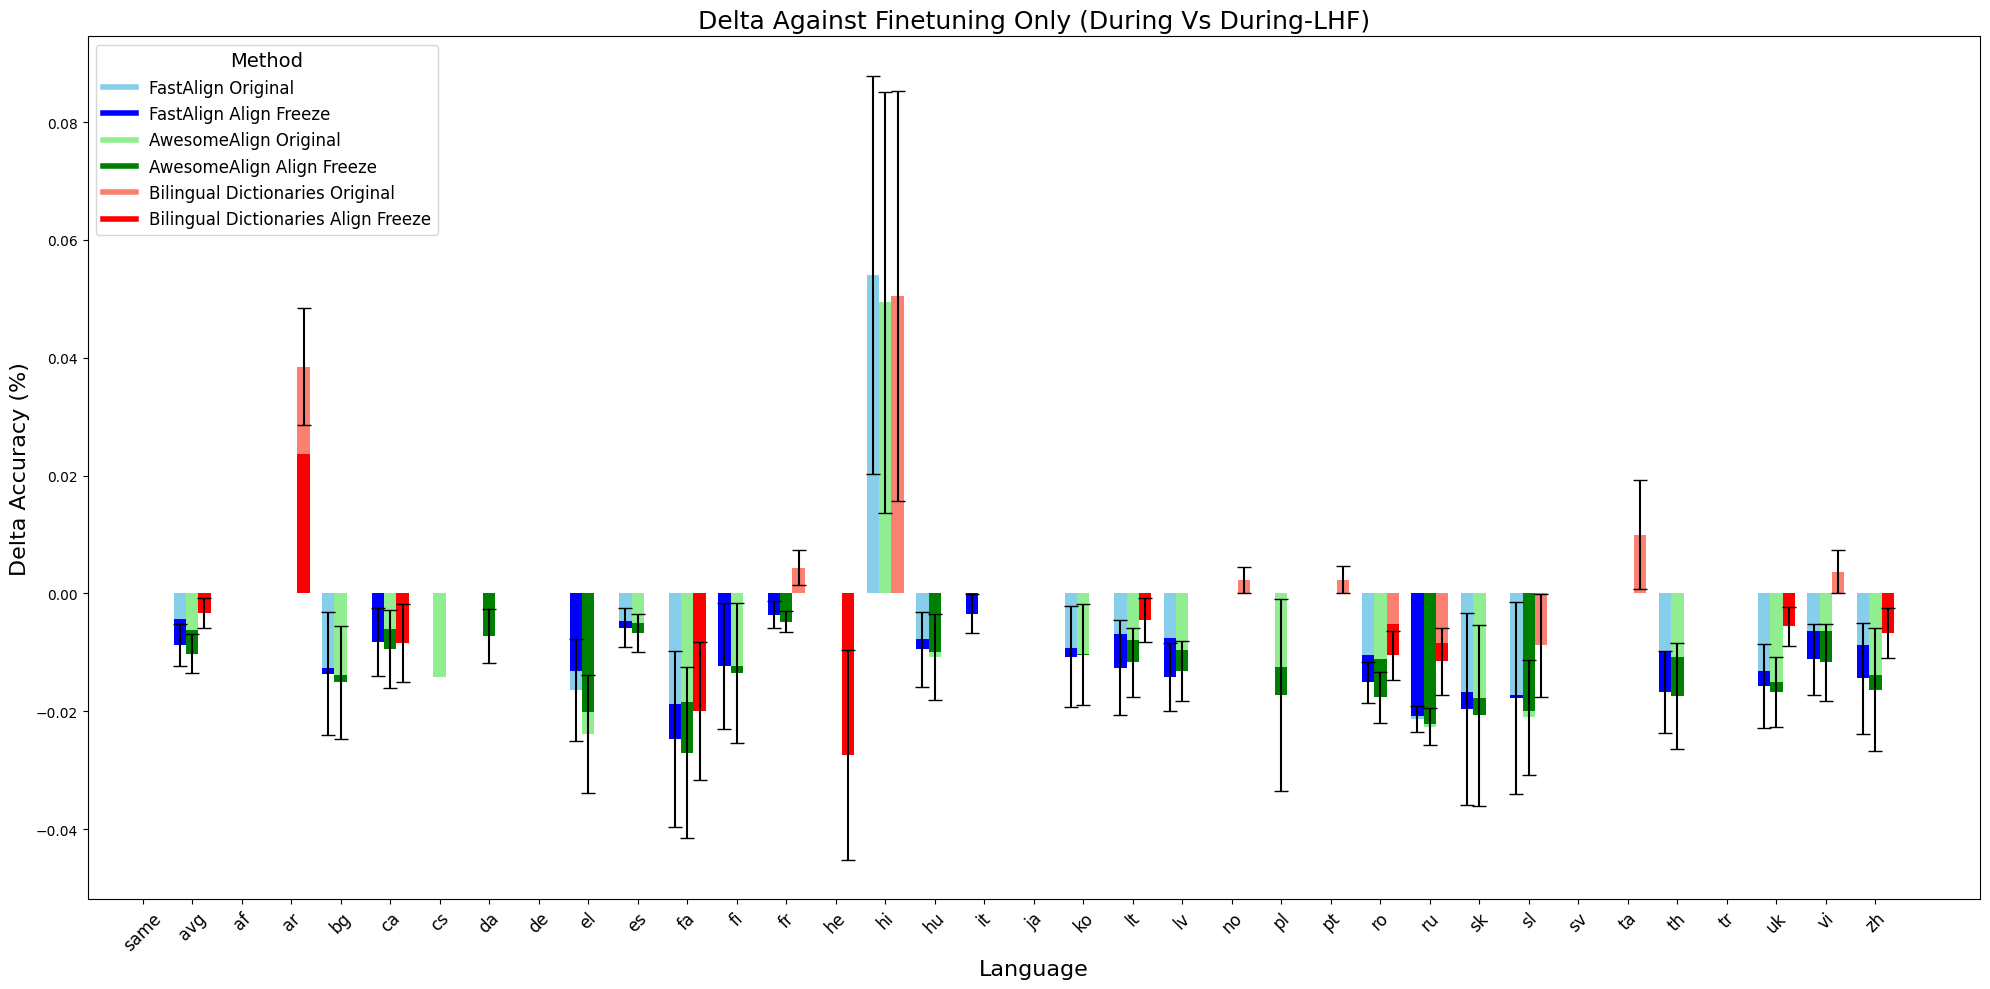

In [21]:
project_pairs = [
    ("3nl_34langs_during_fastalign_udpos", "3nl_34langs_during_partial_freeze_back_fastalign_udpos"),
    ("3nl_34langs_during_awesome_udpos", "3nl_34langs_during_partial_freeze_back_awesome_udpos"),
    ("3nl_34langs_during_dico_udpos", "3nl_34langs_during_partial_freeze_back_dico_udpos"),
]

show = True

plot_layered_bar_deltas(project_pairs, langs, finetuning_project_name=finetuning_project_name, 
                        title='Delta Against Finetuning Only (During Vs During-LHF)',
                        show_error_bars=show, 
                        hide_bars_crossing_zero=show)

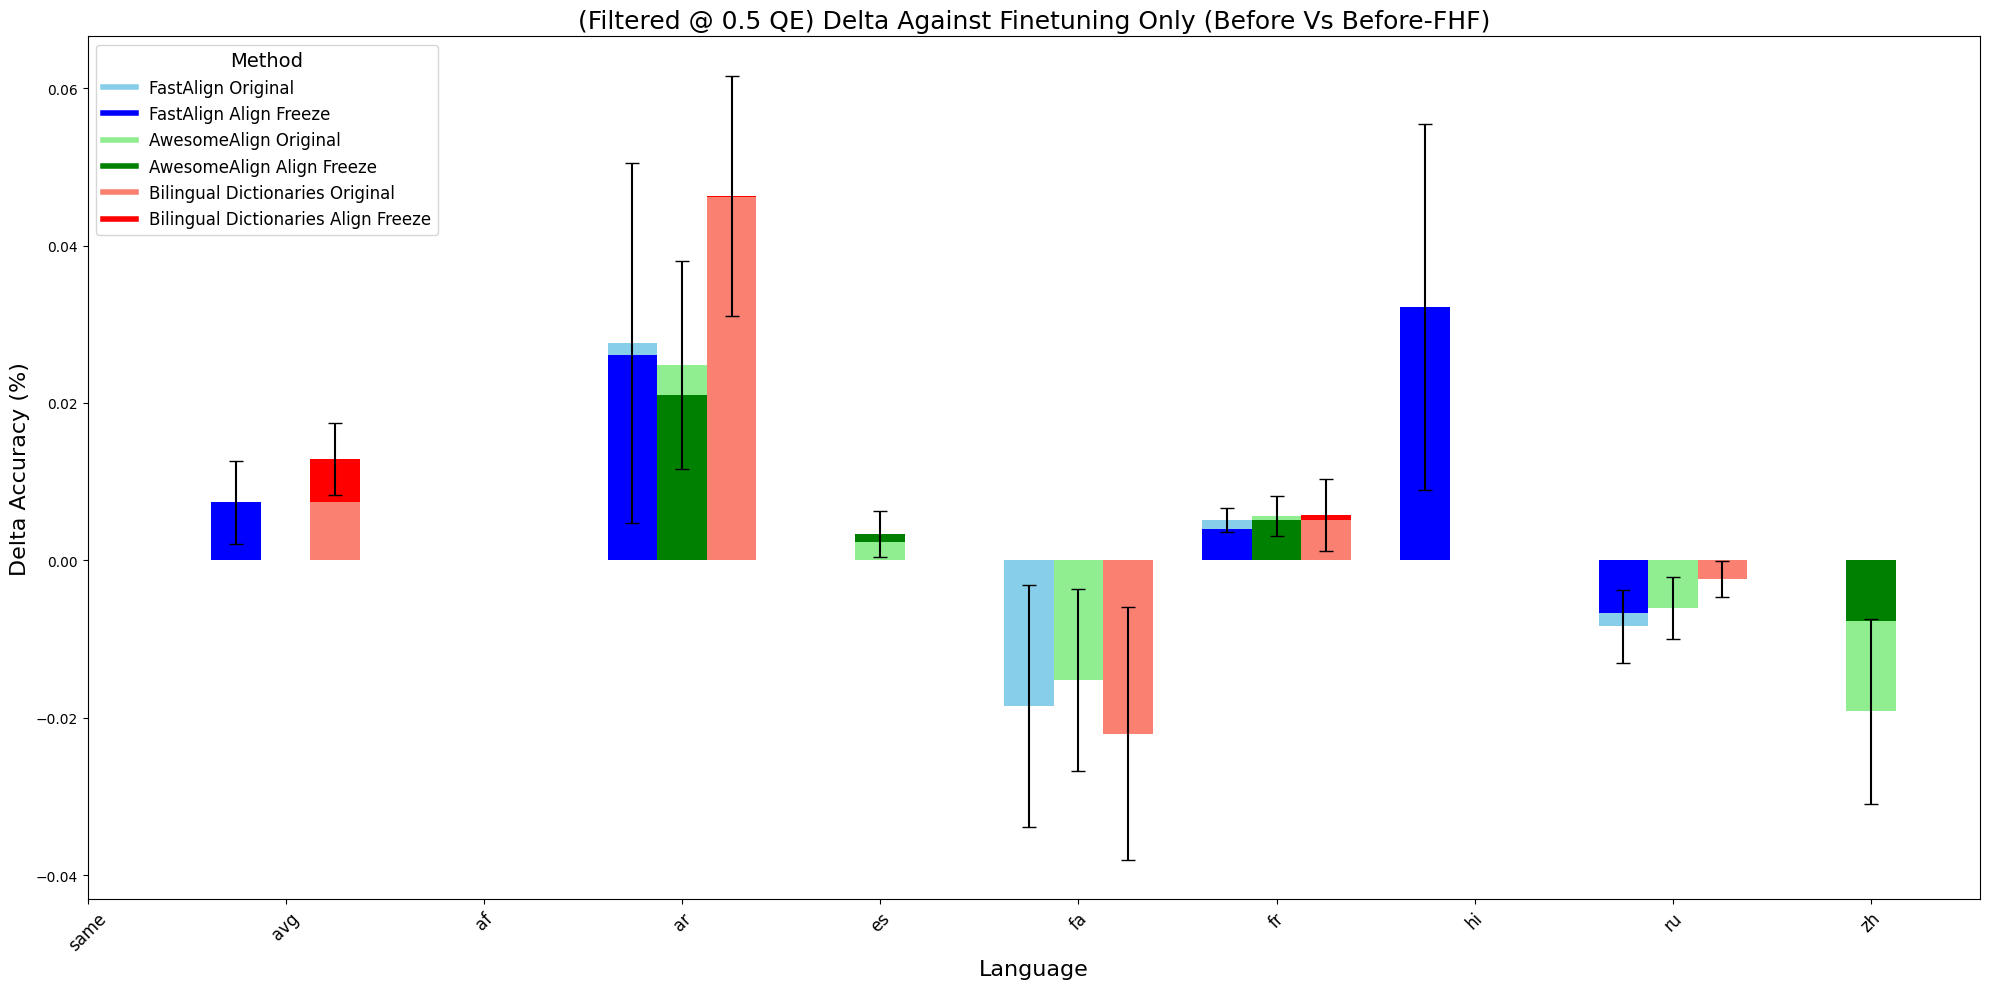

In [22]:
project_pairs = [
    ("3nl_filtered_0.5_before_fastalign_udpos", "3nl_filtered_0.5_freeze_realign_unfreeze_fastalign_udpos"),
    ("3nl_filtered_0.5_before_awesome_udpos", "3nl_filtered_0.5_freeze_realign_unfreeze_awesome_udpos"),
    ("3nl_filtered_0.5_before_dico_udpos", "3nl_filtered_0.5_freeze_realign_unfreeze_dico_udpos"),
]

show = True

plot_layered_bar_deltas(project_pairs, filtered_langs, finetuning_project_name='3nl_filtered_0.5_baseline_udpos', 
                        title='(Filtered @ 0.5 QE) Delta Against Finetuning Only (Before Vs Before-FHF)',
                        show_error_bars=show, 
                        hide_bars_crossing_zero=show)

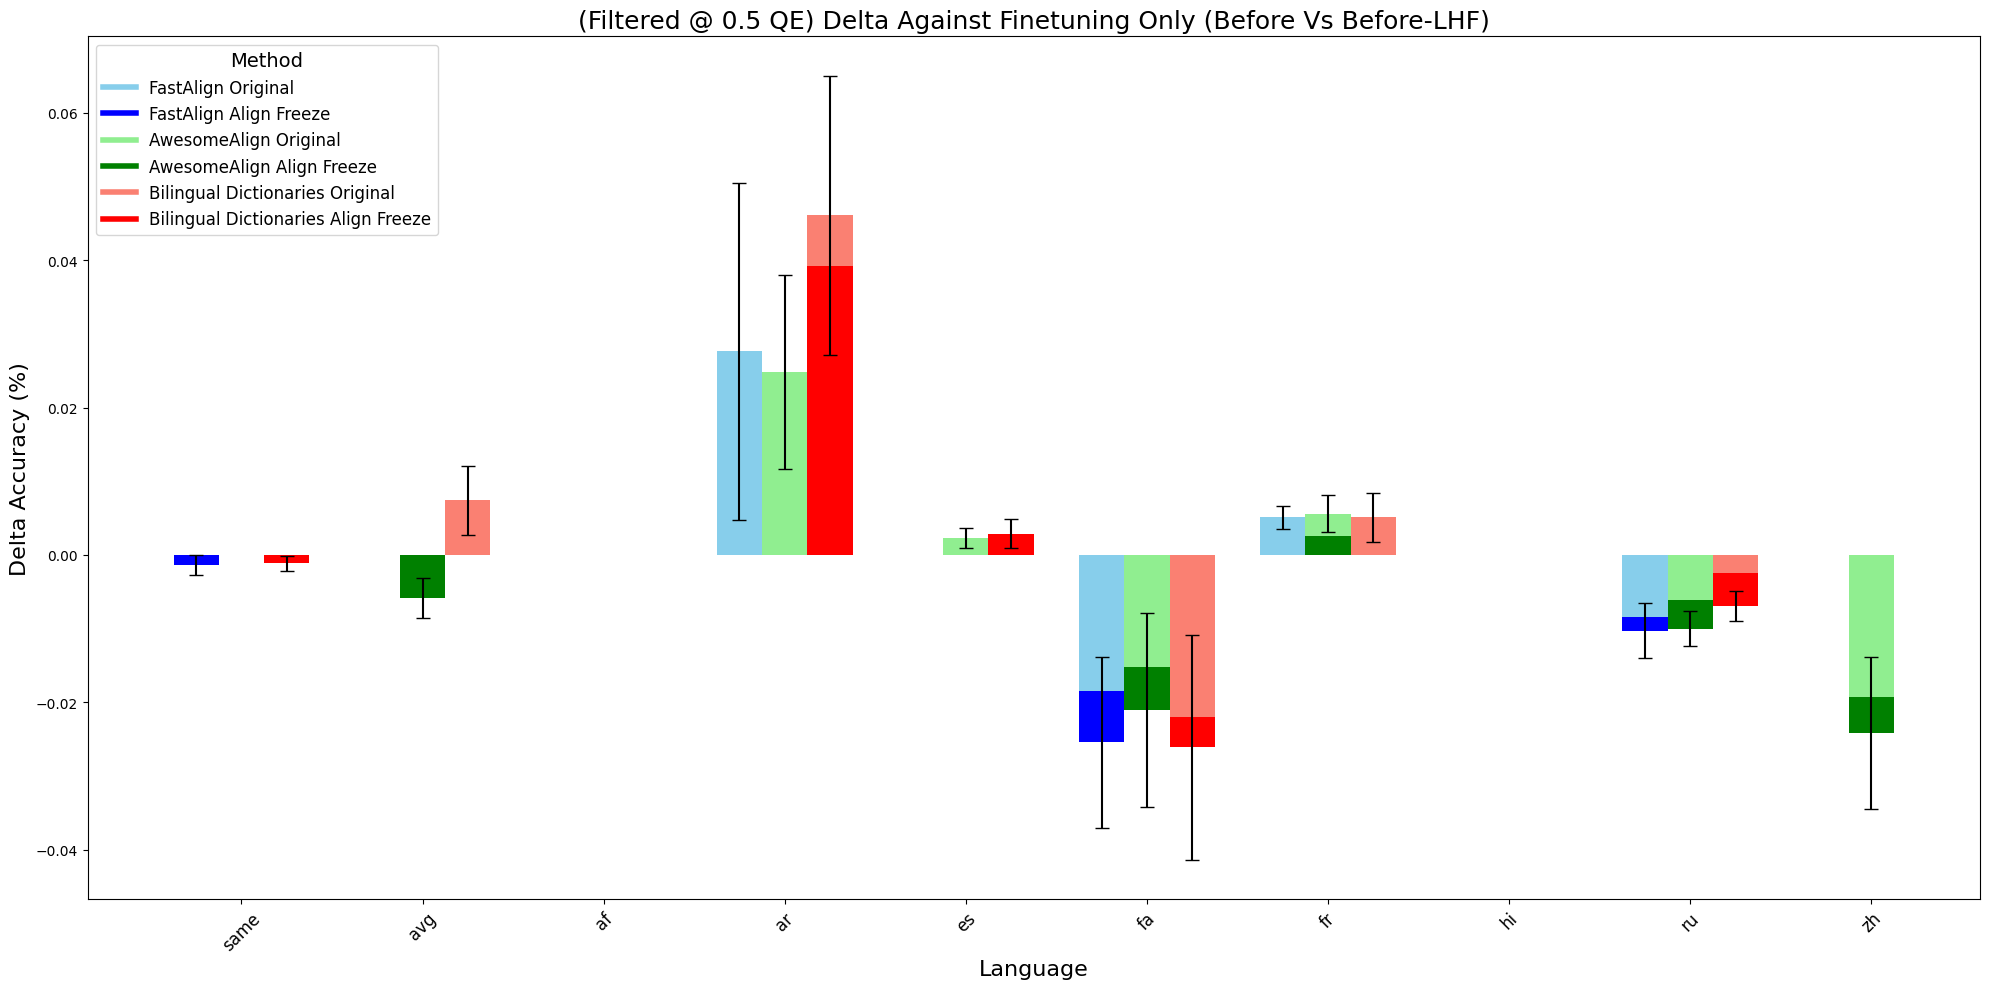

In [23]:
project_pairs = [
    ("3nl_filtered_0.5_before_fastalign_udpos", "3nl_filtered_0.5_freeze_realign_unfreeze_last_6_fastalign_udpos"),
    ("3nl_filtered_0.5_before_awesome_udpos", "3nl_filtered_0.5_freeze_realign_unfreeze_last_6_awesome_udpos"),
    ("3nl_filtered_0.5_before_dico_udpos", "3nl_filtered_0.5_freeze_realign_unfreeze_last_6_dico_udpos"),
]

show = True

plot_layered_bar_deltas(project_pairs, filtered_langs, finetuning_project_name='3nl_filtered_0.5_baseline_udpos', 
                        title='(Filtered @ 0.5 QE) Delta Against Finetuning Only (Before Vs Before-LHF)',
                        show_error_bars=show, 
                        hide_bars_crossing_zero=show)

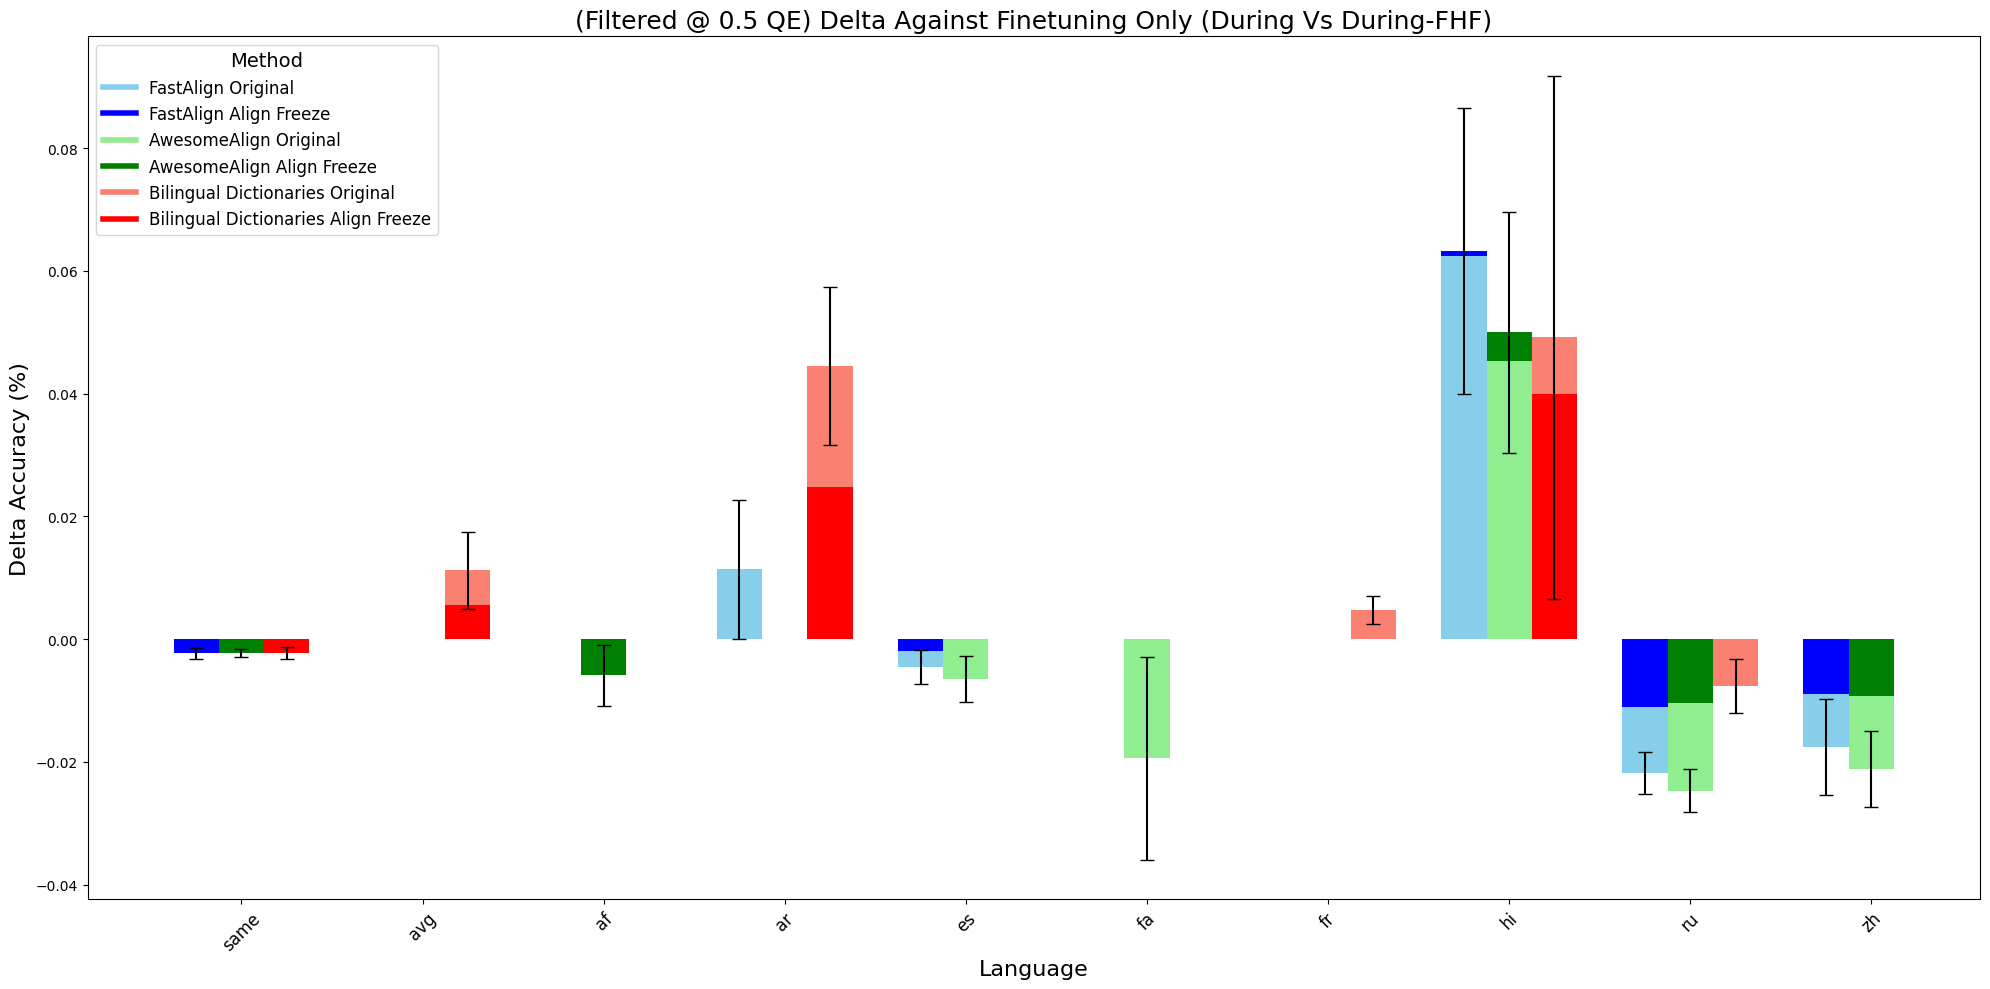

In [24]:
project_pairs = [
    ("3nl_filtered_0.5_during_fastalign_udpos", "3nl_filtered_0.5_during_partial_freeze_front_fastalign_udpos"),
    ("3nl_filtered_0.5_during_awesome_udpos", "3nl_filtered_0.5_during_partial_freeze_front_awesome_udpos"),
    ("3nl_filtered_0.5_during_dico_udpos", "3nl_filtered_0.5_during_partial_freeze_front_dico_udpos"),
]

show = True

plot_layered_bar_deltas(project_pairs, filtered_langs, finetuning_project_name='3nl_filtered_0.5_baseline_udpos', 
                        title='(Filtered @ 0.5 QE) Delta Against Finetuning Only (During Vs During-FHF)',
                        show_error_bars=show, 
                        hide_bars_crossing_zero=show)

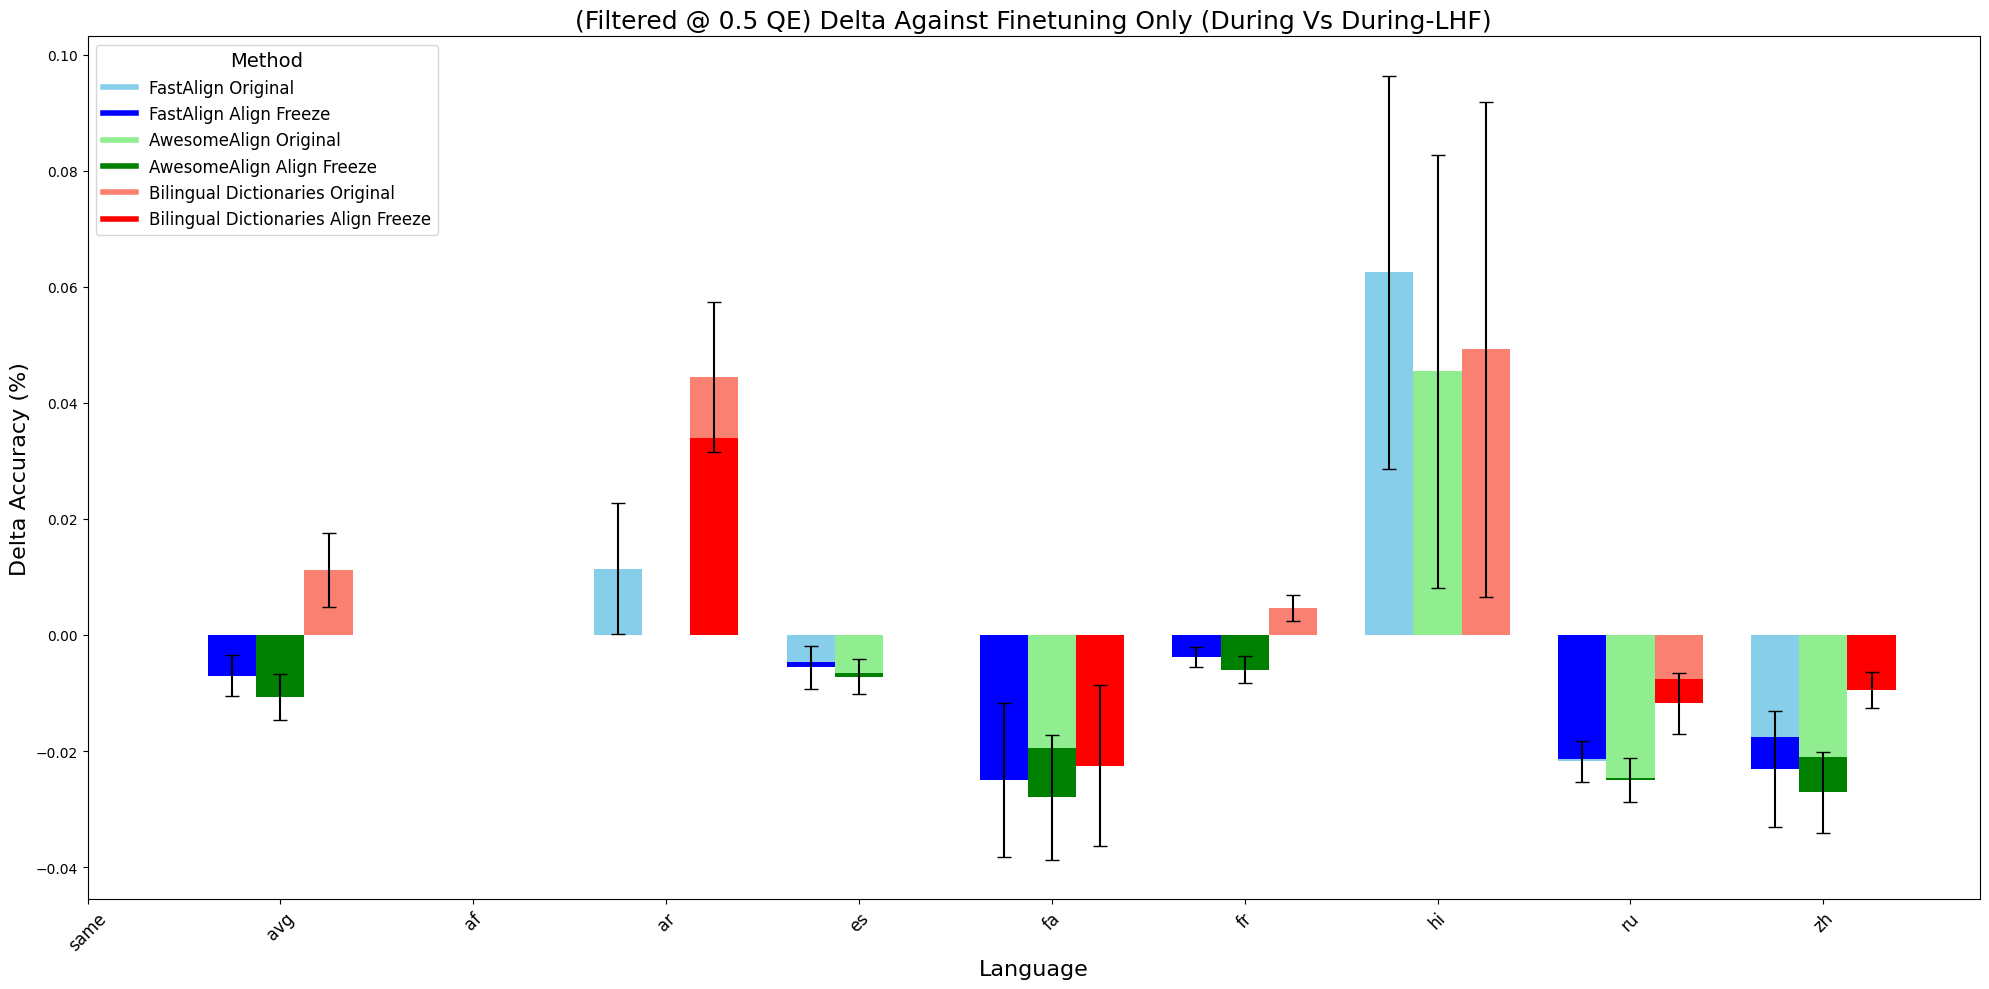

In [25]:
project_pairs = [
    ("3nl_filtered_0.5_during_fastalign_udpos", "3nl_filtered_0.5_during_partial_freeze_back_fastalign_udpos"),
    ("3nl_filtered_0.5_during_awesome_udpos", "3nl_filtered_0.5_during_partial_freeze_back_awesome_udpos"),
    ("3nl_filtered_0.5_during_dico_udpos", "3nl_filtered_0.5_during_partial_freeze_back_dico_udpos"),
]

show = True

plot_layered_bar_deltas(project_pairs, filtered_langs, finetuning_project_name='3nl_filtered_0.5_baseline_udpos', 
                        title='(Filtered @ 0.5 QE) Delta Against Finetuning Only (During Vs During-LHF)',
                        show_error_bars=show, 
                        hide_bars_crossing_zero=show)

In [26]:
project_pairs = [
    ("3nl_filtered_0.7_before_fastalign_udpos", "3nl_filtered_0.7_freeze_realign_unfreeze_fastalign_udpos"),
    ("3nl_filtered_0.7_before_awesome_udpos", "3nl_filtered_0.7_freeze_realign_unfreeze_awesome_udpos"),
    ("3nl_filtered_0.7_before_dico_udpos", "3nl_filtered_0.7_freeze_realign_unfreeze_dico_udpos"),
]

show = False

plot_layered_bar_deltas(project_pairs, filtered_langs, finetuning_project_name='3nl_filtered_0.7_baseline_udpos', 
                        title='(Filtered @ 0.7 QE) Delta Against Finetuning Only (Before Vs Before-FHF)',
                        show_error_bars=show, 
                        hide_bars_crossing_zero=show)

ValueError: Could not find project 3nl_filtered_0.7_freeze_realign_unfreeze_fastalign_udpos

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.lines as mlines



def plot_individual_violin_deltas_with_cis(project_pairs, langs, baseline_name=None, new_name=None):
    aligners = ['FastAlign', 'AwesomeAlign', 'Bilingual Dictionaries']
    for projects, aligner in zip(project_pairs, aligners):
        baseline_project, align_freeze_project = projects
        
        baseline_data = fetch_and_process_runs(baseline_project)
        align_freeze_data = fetch_and_process_runs(align_freeze_project)

        
        delta_data = []

        
        for lang in langs:
            lang_deltas = [align_freeze - baseline for baseline, align_freeze in zip(baseline_data[lang], align_freeze_data[lang])]
            mean_delta = np.mean(lang_deltas)
            ci = scipy.stats.sem(lang_deltas) * scipy.stats.t.ppf((1 + 0.95) / 2., len(lang_deltas)-1)
            delta_data.extend([{'Language': lang, 'Delta': delta, 'Mean Delta': mean_delta, 'CI': ci} for delta in lang_deltas])

        
        df = pd.DataFrame(delta_data)

        
        plt.figure(figsize=(10, 6))
        ax = sns.violinplot(x='Language', y='Delta', data=df, inner='quartile', palette='coolwarm', dodge=False, hue='Language')
        ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])

        
        
        means = df.groupby('Language')['Delta'].mean().reindex(langs)
        cis = df.groupby('Language')['CI'].mean().reindex(langs)

        
        error_bars = plt.errorbar(range(len(langs)), means, yerr=cis, fmt='o', color='black', capsize=5, label='Mean Delta ± CI')

        
        
        
        
        
        
        

        plt.title(f'Delta Accuracy ({new_name} minus {baseline_name}) for {aligner}')
        plt.axhline(0, color='grey', linewidth=0.8)  
        plt.ylabel('Delta Accuracy')
        plt.xticks(rotation=45)

        
        quartiles_median_line = mlines.Line2D([], [], color='black', linestyle='--', label='Quartiles/Median')
        mean_delta_ci_line = mlines.Line2D([], [], color='black', marker='o', linestyle='None', label='Mean Delta ± CI')

        
        ax.legend(handles=[quartiles_median_line, mean_delta_ci_line], loc='lower right', title="Legend")

        plt.tight_layout()
        plt.show()

plot_individual_violin_deltas_with_cis(project_pairs, langs, baseline_name='Felix Before Method', new_name='Front Half Frozen Before Method')

In [ ]:
plot_individual_violin_deltas_with_cis([('3nl_34langs_baseline_udpos', '3nl_34langs_freeze_realign_unfreeze_fastalign_udpos'),
                                        ('3nl_34langs_baseline_udpos', '3nl_34langs_freeze_realign_unfreeze_awesome_udpos'),
                                        ('3nl_34langs_baseline_udpos', '3nl_34langs_freeze_realign_unfreeze_dico_udpos'),], langs, 
                                       baseline_name='Finetuning Only', new_name='Front Half Frozen Before Method')

In [ ]:
plot_individual_violin_deltas_with_cis([('3nl_34langs_baseline_udpos', '3nl_34langs_before_fastalign_udpos'),
                                        ('3nl_34langs_baseline_udpos', '3nl_34langs_before_awesome_udpos'),
                                        ('3nl_34langs_baseline_udpos', '3nl_34langs_before_dico_udpos'),], langs, 
                                       baseline_name='Finetuning Only', new_name="Felix's Before Method")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import seaborn as sns
import pandas as pd
from IPython.display import display

def plot_violin_deltas_with_summary_and_cis(project_pairs, langs, grouping, grouping_type):
    for baseline_project, aligned_project in project_pairs:
        
        baseline_data = fetch_and_process_runs(baseline_project)
        aligned_data = fetch_and_process_runs(aligned_project)
        delta_data = []
        summary_stats = []

        for lang in langs:
            if lang in ['avg', 'same']:  
                continue
            lang_deltas = [aligned - baseline for baseline, aligned in zip(baseline_data.get(lang, []), aligned_data.get(lang, []))]
            group = grouping.get(lang, 'Other')
            delta_data.extend([{'Group': group, 'Delta': delta} for delta in lang_deltas])
            mean_delta = np.mean(lang_deltas)
            ci = scipy.stats.sem(lang_deltas) * scipy.stats.t.ppf((1 + 0.95) / 2., len(lang_deltas)-1) if len(lang_deltas) > 1 else 0
            summary_stats.append((group, 'Increase' if mean_delta - ci > 0 else 'Decrease' if mean_delta + ci < 0 else 'No Change'))

        
        df = pd.DataFrame(delta_data)
        plt.figure(figsize=(12, 6))
        order = sorted(set(grouping.values()))  
        ax = sns.violinplot(x='Group', y='Delta', data=df, inner='quartile', palette='coolwarm', order=order, hue='Group')

        
        for i, group in enumerate(order):
            group_data = df[df['Group'] == group]['Delta']
            mean = group_data.mean()
            ci = scipy.stats.sem(group_data) * scipy.stats.t.ppf((1 + 0.95) / 2., len(group_data)-1) if len(group_data) > 1 else 0
            plt.errorbar(i, mean, yerr=ci, fmt='o', color='black', capsize=5, capthick=2)

        plt.title(f'Delta Accuracy (Aligned minus Baseline) for {aligned_project.split("_")[-1]} - Grouped by {grouping_type}')
        plt.axhline(0, color='grey', linewidth=0.8)
        plt.ylabel('Delta Accuracy')
        plt.xlabel(grouping_type)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        
        summary_df = pd.DataFrame(summary_stats, columns=['Group', 'Change'])
        summary_counts = summary_df.groupby(['Group', 'Change']).size().unstack(fill_value=0)
        summary_counts['Total'] = summary_counts.sum(axis=1)
        print("Statistical Significance Summary:")
        display(summary_counts)


In [ ]:
language_script = {
    "same": "Latin",  
    "af": "Latin",
    "ar": "Arabic",
    "bg": "Cyrillic",
    "ca": "Latin",
    "cs": "Latin",
    "da": "Latin",
    "de": "Latin",
    "el": "Greek",
    "es": "Latin",
    "fa": "Arabic",
    "fi": "Latin",
    "fr": "Latin",
    "he": "Hebrew",
    "hi": "Devanagari",
    "hu": "Latin",
    "it": "Latin",
    "ja": "Kanji, Hiragana, Katakana",
    "ko": "Hangul",
    "lt": "Latin",
    "lv": "Latin",
    "no": "Latin",
    "pl": "Latin",
    "pt": "Latin",
    "ro": "Latin",
    "ru": "Cyrillic",
    "sk": "Latin",
    "sl": "Latin",
    "sv": "Latin",
    "ta": "Tamil",
    "th": "Thai",
    "tr": "Latin",
    "uk": "Cyrillic",
    "vi": "Latin",
    "zh": "Han"
}

plot_violin_deltas_with_summary_and_cis(project_pairs, langs, language_script, 'Script Type')

In [ ]:
language_word_order = {
    "same": "SVO",  
    "af": "SVO",
    "ar": "VSO",
    "bg": "SVO",
    "ca": "SVO",
    "cs": "SVO",
    "da": "SVO",
    "de": "SOV",
    "el": "SVO",
    "es": "SVO",
    "fa": "SOV",
    "fi": "SVO",
    "fr": "SVO",
    "he": "SVO",
    "hi": "SOV",
    "hu": "SOV",
    "it": "SVO",
    "ja": "SOV",
    "ko": "SOV",
    "lt": "SVO",
    "lv": "SVO",
    "no": "SVO",
    "pl": "SVO",
    "pt": "SVO",
    "ro": "SVO",
    "ru": "SVO",
    "sk": "SVO",
    "sl": "SVO",
    "sv": "SVO",
    "ta": "SOV",
    "th": "SVO",
    "tr": "SOV",
    "uk": "SVO",
    "vi": "SVO",
    "zh": "SVO"
}

plot_violin_deltas_with_summary_and_cis(project_pairs, langs, language_word_order, 'Word Order')

In [ ]:
language_morphology = {
    "same": "Analytic",  
    "af": "Agglutinative",
    "ar": "Fusional",
    "bg": "Fusional",
    "ca": "Agglutinative",
    "cs": "Fusional",
    "da": "Analytic",
    "de": "Fusional",
    "el": "Fusional",
    "es": "Fusional",
    "fa": "Agglutinative",
    "fi": "Agglutinative",
    "fr": "Fusional",
    "he": "Fusional",
    "hi": "Agglutinative",
    "hu": "Agglutinative",
    "it": "Fusional",
    "ja": "Agglutinative",
    "ko": "Agglutinative",
    "lt": "Inflective",
    "lv": "Inflective",
    "no": "Analytic",
    "pl": "Inflective",
    "pt": "Fusional",
    "ro": "Fusional",
    "ru": "Fusional",
    "sk": "Inflective",
    "sl": "Inflective",
    "sv": "Analytic",
    "ta": "Agglutinative",
    "th": "Analytic",
    "tr": "Agglutinative",
    "uk": "Fusional",
    "vi": "Analytic",
    "zh": "Isolating"
}

plot_violin_deltas_with_summary_and_cis(project_pairs, langs, language_morphology, 'Morphological Complexity')

In [ ]:
language_syntax_flexibility = {
    "same": "Fixed",
    "af": "Moderate",
    "ar": "Moderate",
    "bg": "Flexible",
    "ca": "Flexible",
    "cs": "Flexible",
    "da": "Fixed",
    "de": "Flexible",
    "el": "Moderate",
    "es": "Fixed",
    "fa": "Flexible",
    "fi": "Flexible",
    "fr": "Fixed",
    "he": "Moderate",
    "hi": "Flexible",
    "hu": "Flexible",
    "it": "Fixed",
    "ja": "Flexible",
    "ko": "Flexible",
    "lt": "Flexible",
    "lv": "Flexible",
    "no": "Fixed",
    "pl": "Flexible",
    "pt": "Fixed",
    "ro": "Fixed",
    "ru": "Flexible",
    "sk": "Flexible",
    "sl": "Flexible",
    "sv": "Fixed",
    "ta": "Flexible",
    "th": "Flexible",
    "tr": "Flexible",
    "uk": "Flexible",
    "vi": "Fixed",
    "zh": "Fixed"
}

plot_violin_deltas_with_summary_and_cis(project_pairs, langs, language_syntax_flexibility, 'Syntactic Flexibility')

In [ ]:
language_semantic_ambiguity = {
    "same": "Low",
    "af": "Low",
    "ar": "High",
    "bg": "Low",
    "ca": "Low",
    "cs": "Moderate",
    "da": "Low",
    "de": "High",
    "el": "Moderate",
    "es": "Low",
    "fa": "High",
    "fi": "Low",
    "fr": "Low",
    "he": "High",
    "hi": "Moderate",
    "hu": "High",
    "it": "Low",
    "ja": "High",
    "ko": "High",
    "lt": "Moderate",
    "lv": "Moderate",
    "no": "Low",
    "pl": "Moderate",
    "pt": "Low",
    "ro": "Low",
    "ru": "Moderate",
    "sk": "Moderate",
    "sl": "Moderate",
    "sv": "Low",
    "ta": "Low",
    "th": "High",
    "tr": "Low",
    "uk": "Moderate",
    "vi": "Low",
    "zh": "High"
}

plot_violin_deltas_with_summary_and_cis(project_pairs, langs, language_semantic_ambiguity, 'Semantic Ambiguity')

In [ ]:
language_geographical_region = {
    "same": "Europe/North America",  
    "af": "Africa",
    "ar": "Middle East/North Africa",
    "bg": "Europe",
    "ca": "Europe",
    "cs": "Europe",
    "da": "Europe",
    "de": "Europe",
    "el": "Europe",
    "es": "Europe/Latin America",
    "fa": "Middle East",
    "fi": "Europe",
    "fr": "Europe/Africa",
    "he": "Middle East",
    "hi": "South Asia",
    "hu": "Europe",
    "it": "Europe",
    "ja": "East Asia",
    "ko": "East Asia",
    "lt": "Europe",
    "lv": "Europe",
    "no": "Europe",
    "pl": "Europe",
    "pt": "Europe/South America",
    "ro": "Europe",
    "ru": "Europe/Asia",
    "sk": "Europe",
    "sl": "Europe",
    "sv": "Europe",
    "ta": "South Asia",
    "th": "Southeast Asia",
    "tr": "Middle East/Europe",
    "uk": "Europe",
    "vi": "Southeast Asia",
    "zh": "East Asia"
}


plot_violin_deltas_with_summary_and_cis(project_pairs, langs, language_geographical_region, 'Geographical Region')

In [ ]:
language_family = {
    "same": "Indo-European",  
    "af": "Indo-European",
    "ar": "Afro-Asiatic",
    "bg": "Indo-European",
    "ca": "Indo-European",
    "cs": "Indo-European",
    "da": "Indo-European",
    "de": "Indo-European",
    "el": "Indo-European",
    "es": "Indo-European",
    "fa": "Indo-European",
    "fi": "Uralic",
    "fr": "Indo-European",
    "he": "Afro-Asiatic",
    "hi": "Indo-European",
    "hu": "Uralic",
    "it": "Indo-European",
    "ja": "Japonic",
    "ko": "Koreanic",
    "lt": "Indo-European",
    "lv": "Indo-European",
    "no": "Indo-European",
    "pl": "Indo-European",
    "pt": "Indo-European",
    "ro": "Indo-European",
    "ru": "Indo-European",
    "sk": "Indo-European",
    "sl": "Indo-European",
    "sv": "Indo-European",
    "ta": "Dravidian",
    "th": "Kra-Dai",
    "tr": "Turkic",
    "uk": "Indo-European",
    "vi": "Austroasiatic",
    "zh": "Sino-Tibetan"
}

plot_violin_deltas_with_summary_and_cis(project_pairs, langs, language_family, 'Writing System Age')

In [ ]:
language_digital_presence = {
    "same": "High",  
    "af": "Low",
    "ar": "Medium",
    "bg": "Low",
    "ca": "Low",
    "cs": "Low",
    "da": "Medium",
    "de": "High",
    "el": "Medium",
    "es": "High",
    "fa": "Medium",
    "fi": "Medium",
    "fr": "High",
    "he": "Medium",
    "hi": "Medium",
    "hu": "Low",
    "it": "High",
    "ja": "High",
    "ko": "High",
    "lt": "Low",
    "lv": "Low",
    "no": "Medium",
    "pl": "Medium",
    "pt": "High",
    "ro": "Low",
    "ru": "High",
    "sk": "Low",
    "sl": "Low",
    "sv": "Medium",
    "ta": "Low",
    "th": "Medium",
    "tr": "Medium",
    "uk": "Low",
    "vi": "Low",
    "zh": "High"
}

plot_violin_deltas_with_summary_and_cis(project_pairs, langs, language_digital_presence, 'Internet Penetration and Digital Presence')


In [ ]:
language_writing_system_age = {
    "same": "Modern",  
    "af": "Modern",
    "ar": "Ancient",
    "bg": "Medieval",
    "ca": "Modern",
    "cs": "Medieval",
    "da": "Modern",
    "de": "Modern",
    "el": "Ancient",
    "es": "Modern",
    "fa": "Ancient",
    "fi": "Modern",
    "fr": "Modern",
    "he": "Ancient",
    "hi": "Ancient",
    "hu": "Modern",
    "it": "Modern",
    "ja": "Ancient",
    "ko": "Medieval",
    "lt": "Modern",
    "lv": "Modern",
    "no": "Modern",
    "pl": "Modern",
    "pt": "Modern",
    "ro": "Modern",
    "ru": "Medieval",
    "sk": "Modern",
    "sl": "Modern",
    "sv": "Modern",
    "ta": "Ancient",
    "th": "Ancient",
    "tr": "Modern",
    "uk": "Medieval",
    "vi": "Modern",
    "zh": "Ancient"
}

plot_violin_deltas_with_summary_and_cis(project_pairs, langs, language_writing_system_age, 'Writing System Age')

In [ ]:
language_pretraining_sizes = {
    "af": 242, "am": 68, "ar": 2869, "as": 5, "az": 783,
    "be": 362, "bg": 5487, "bn": 525, "br": 16, "bs": 14,
    "ca": 1752, "cs": 2498, "cy": 141, "da": 7823, "de": 10297,
    "el": 4285, "en": 55608, "eo": 157, "es": 9374, "et": 843,
    "eu": 270, "fa": 13259, "fi": 6730, "fr": 9780, "fy": 29,
    "ga": 86, "gd": 21, "gl": 495, "gu": 31806, "ha": 56,
    "he": 3399, "hi": 1715, "hr": 3297, "hu": 7807, "hy": 421,
    "id": 22704, "is": 505, "it": 4983, "ja": 530, "jv": 24,
    "ka": 469, "kk": 776, "km": 11483, "kn": 14537, "ko": 5644,
    "ku": 66, "ky": 14484, "la": 390, "lt": 1835, "lv": 1198,
    "mg": 25, "mk": 449, "ml": 313, "mn": 248, "mr": 175,
    "ms": 1318, "mt": 14, "my": 71, "ne": 237, "nl": 5025,
    "no": 8494, "om": 8, "or": 36, "pa": 68, "pl": 6490,
    "ps": 96, "pt": 8405, "ro": 10354, "ru": 23408, "rw": 173823,
    "sd": 50, "si": 243, "sk": 3525, "sl": 1669, "so": 62,
    "sq": 918, "sr": 843, "su": 10, "sv": 7778, "sw": 275,
    "ta": 631, "te": 249, "th": 1834, "tl": 556, "tr": 2736,
    "ug": 27, "uk": 6500, "ur": 815, "uz": 91, "vi": 24757,
    "xh": 13, "yi": 34, "zh": 435, 
}


size_categories = {
    "Very Low Resource": (0, 50),
    "Low Resource": (50, 500),
    "Medium Resource": (500, 5000),
    "High Resource": (5000, 20000),
    "Very High Resource": (20000, max(language_pretraining_sizes.values()) + 1)  
}


language_size_category = {lang: next((category for category, (low, high) in size_categories.items() if low <= size <= high), "Unknown")
                          for lang, size in language_pretraining_sizes.items()}


plot_violin_deltas_with_summary_and_cis(project_pairs, langs, language_size_category, 'XLM-R Pretraining Data Size')

In [ ]:

opus100_sizes = {
    "af": 275512, "am": 89027, "an": 6961, "ar": 1000000, "as": 138479,
    "az": 262089, "be": 67312, "bg": 1000000, "bn": 1000000, "br": 153447,
    "bs": 1000000, "ca": 1000000, "cs": 1000000, "cy": 289521, "da": 1000000,
    "de": 1000000, "dz": 624, "el": 1000000, "eo": 337106, "es": 1000000,
    "et": 1000000, "eu": 1000000, "fa": 1000000, "fi": 1000000, "fr": 1000000,
    "fy": 54342, "ga": 289524, "gd": 16316, "gl": 515344, "gu": 318306,
    "ha": 97983, "he": 1000000, "hi": 534319, "hr": 1000000, "hu": 1000000,
    "hy": 7059, "id": 1000000, "ig": 18415, "is": 1000000, "it": 1000000,
    "ja": 1000000, "ka": 377306, "kk": 79927, "km": 111483, "kn": 14537,
    "ko": 1000000, "ku": 144844, "ky": 27215, "li": 25535, "lt": 1000000,
    "lv": 1000000, "mg": 590771, "mk": 1000000, "ml": 822746, "mn": 4294,
    "mr": 27007, "ms": 1000000, "mt": 1000000, "my": 24594, "nb": 142906,
    "ne": 406381, "nl": 1000000, "nn": 486055, "no": 1000000, "oc": 35791,
    "or": 14273, "pa": 107296, "pl": 1000000, "ps": 79127, "pt": 1000000,
    "ro": 1000000, "ru": 1000000, "rw": 173823, "se": 35907, "sh": 267211,
    "si": 979109, "sk": 1000000, "sl": 1000000, "sq": 1000000, "sr": 1000000,
    "sv": 1000000, "sw": 275, "ta": 227014, "te": 64352, "tg": 193882,
    "th": 1000000, "tk": 13110, "tr": 1000000, "tt": 100843, "ug": 72170,
    "uk": 1000000, "ur": 753913, "uz": 173157, "vi": 1000000, "wa": 104496,
    "xh": 439671, "yi": 15010, "yo": 10375, "zh": 1000000, "zu": 38616,
    "same": 1000000  
}


opus_data_size = {
    
}


for lang in langs:
    if lang == 'avg':
        continue
    size = opus100_sizes.get(lang, 0)  
    category = ''
    if size >= 1000000:
        category = 'Very High Resource'
    elif size >= 500000:
        category = 'High Resource'
    elif size >= 100000:
        category = 'Medium Resource'
    elif size >= 10000:
        category = 'Low Resource'
    else:
        category = 'Very Low Resource'
   
    opus_data_size[lang] = category

plot_violin_deltas_with_summary_and_cis(project_pairs, langs, opus_data_size, 'Opus100 Data Size')

In [ ]:

xlmr_data_size_categories = {
    lang: next((category for category, (low, high) in size_categories.items() if low <= size <= high), "Unknown")
    for lang, size in language_pretraining_sizes.items()
}


combined_resource_levels = {}


for lang, opus_category in opus_data_size.items():
    xlmr_category = xlmr_data_size_categories.get(lang, "Unknown")  
    
    if opus_category == xlmr_category:
        combined_resource_levels[lang] = opus_category
    else:
        combined_resource_levels[lang] = "Diverse"  

plot_violin_deltas_with_summary_and_cis(project_pairs, langs, combined_resource_levels, 'XLM-R & Opus100 Dataset Sizes')